In [3]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

In [4]:
# importing the file with the combined data of both the hospitals and splitting it into 2 parts
combined = pd.read_csv('sepsis_dataset.csv')

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [5]:
# importing the test and training data

df_train = pd.read_csv('data_part1.csv')
df_test = pd.read_csv('data_part2.csv')

# EDA

In [60]:
#EDA
df_train.head()

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,Unit
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072,NaN
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072,NaN
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072,NaN
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072,NaN
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072,NaN


In [59]:
df_test.head()

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,63.0,1,NaN,NaN,-31.63,1,0,101097
1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,63.0,1,NaN,NaN,-31.63,2,0,101097
2,2,2,90.0,100.0,36.6,105.0,75.0,52.0,17.0,NaN,...,NaN,NaN,63.0,1,NaN,NaN,-31.63,3,0,101097
3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,63.0,1,NaN,NaN,-31.63,4,0,101097
4,4,4,77.0,100.0,NaN,118.0,83.0,58.0,18.0,NaN,...,NaN,NaN,63.0,1,NaN,NaN,-31.63,5,0,101097


In [61]:
# let's list down all the different columns

df_train.columns,df_test.columns

(Index(['Unnamed: 0', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP',
        'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2',
        'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
        'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
        'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
        'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID', 'Unit'],
       dtype='object'),
 Index(['Unnamed: 0', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP',
        'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2',
        'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
        'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
        'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2

In [8]:
# list of all the unique patients
# total number of patients present in the dataset

patients = list(df_test['Patient_ID'].unique())
len(patients)

20000

In [9]:
# Function to draw correlation heat map 

def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
# the features have been removed based on the number of null values and redundancy 

# 'Unnamed: 0'-- this is the index column
# 'SBP' -- MAP is considered instead of SBP and DBP
# 'DBP' -- MAP is considered instead of SBP and DBP
# 'EtCO2' -- It is not readily. available and also not available in the dataset
# 'BaseExcess' -- It is an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here. 
# 'HCO3' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'pH' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PaCO2' -- It is an indicator of respiratory health of an individual, we are considering SaO2 and FiO2 which are more readily avaiilable
# 'Alkalinephos' -- It is an indicator of the health of the liver of an individual, but we are considering Bilirubin instead of this, as data of this is more scarce.
# 'Calcium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Magnesium' -- It is an indicator of metabolism and kidney health, but we are considering Lactate instead as it is more readily available
# 'Phosphate' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Potassium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PTT' -- It is used to check inflammation. We are using WBC counts instead as it is easy to obtain.
# 'Fibrinogen' -- It is used to check blood clotting ability. We are using Platelets instead, as it is easier to obtain.
# 'Unit1' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Unit2' -- Both the columns Unit1 and Unit2 have been merged to form a single column.

columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)
df_train_mod.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')

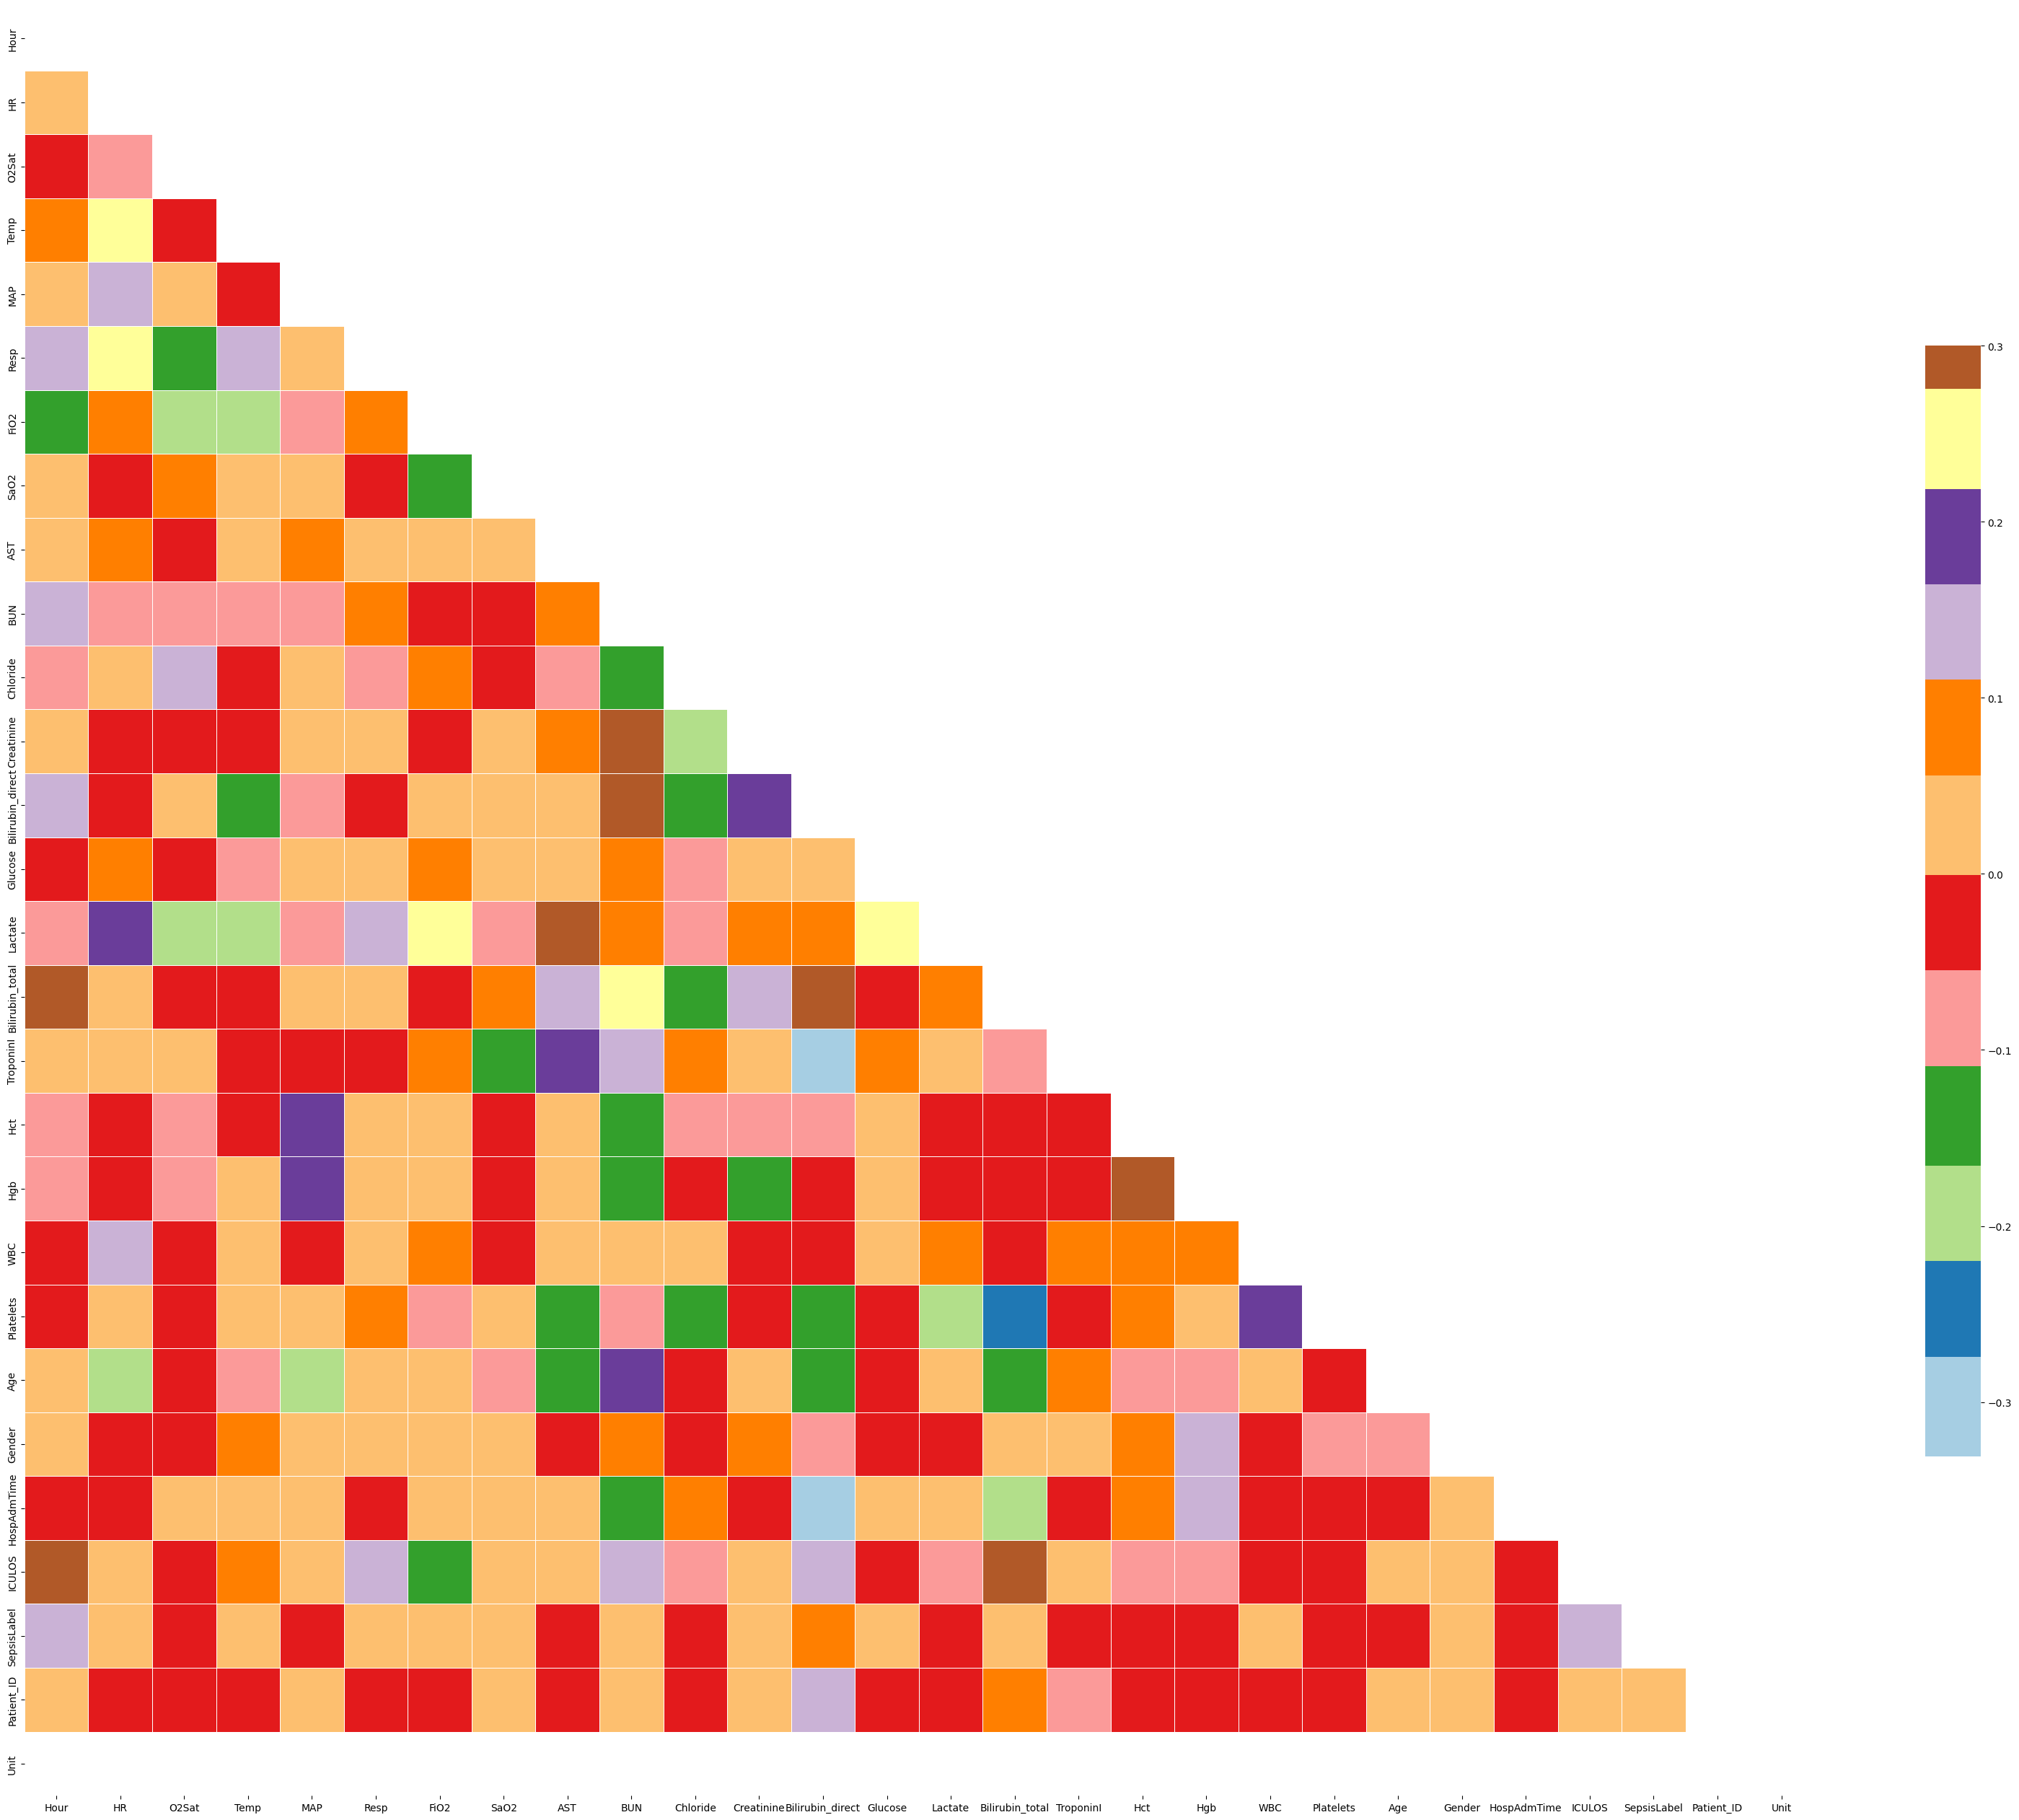

In [12]:
# correlation matrix to check if there is high correlation between the remaining features

corr_matrix(df_train_mod)

In [13]:
'''
Since there are a lot of missing values in the dataset,
therefore imputation was done to fill the missing values. 
While imputing, it is important to note that imputation should be done on per patient basis, 
otherwise the data from one patient will leak into the data of the other patient. 
Also another point that should be taken into consideration is that 
mean, median, mode can not directly be used to impute as it will result in 
uneven distribution of the parameters with respect to time.
'''

df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)
columns_impute

['Hour',
 'HR',
 'O2Sat',
 'Temp',
 'MAP',
 'Resp',
 'FiO2',
 'SaO2',
 'AST',
 'BUN',
 'Chloride',
 'Creatinine',
 'Bilirubin_direct',
 'Glucose',
 'Lactate',
 'Bilirubin_total',
 'TroponinI',
 'Hct',
 'Hgb',
 'WBC',
 'Platelets',
 'Age',
 'Gender',
 'HospAdmTime',
 'ICULOS',
 'SepsisLabel',
 'Patient_ID',
 'Unit']

In [14]:
# bfill and ffill for imputing

grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

In [15]:
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,FiO2,SaO2,AST,BUN,...,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,Unit
0,0,65.0,100.0,35.78,72.0,16.5,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,1,0,17072,NaN
1,1,65.0,100.0,35.78,72.0,16.5,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,2,0,17072,NaN
2,2,78.0,100.0,35.78,42.5,17.0,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,3,0,17072,NaN
3,3,73.0,100.0,35.78,74.0,17.0,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,4,0,17072,NaN
4,4,70.0,100.0,35.78,74.0,14.0,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,5,0,17072,NaN


In [16]:
# Now let's check the remaining proportion of missing values

null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

TroponinI           97.357934
Bilirubin_direct    96.256841
Bilirubin_total     66.949754
AST                 66.435590
SaO2                57.282891
Lactate             55.997418
Unit                48.868346
FiO2                36.195592
WBC                  1.511994
Platelets            1.394810
Chloride             1.310656
Hgb                  1.158672
Creatinine           1.029467
Glucose              0.940630
BUN                  0.937719
Temp                 0.853692
Hct                  0.779028
Resp                 0.088710
O2Sat                0.026702
MAP                  0.003037
HR                   0.001139
HospAdmTime          0.001012
Age                  0.000000
Gender               0.000000
ICULOS               0.000000
SepsisLabel          0.000000
Patient_ID           0.000000
Hour                 0.000000
dtype: float64

In [17]:
'''
'TroponinI', 
'Bilirubin_direct', 
'AST', 
'Bilirubin_total', 
'Lactate', 
'SaO2', 
'FiO2', 
'Unit', 
'Patient_ID' 
have more than 25 percent of null values and hence are dropped from the dataset.
'''

# dropping all the columns with null values more than 25% and patient_id

null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [18]:
df_train_impute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790215 entries, 0 to 790214
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Hour         790215 non-null  int64  
 1   HR           790206 non-null  float64
 2   O2Sat        790004 non-null  float64
 3   Temp         783469 non-null  float64
 4   MAP          790191 non-null  float64
 5   Resp         789514 non-null  float64
 6   BUN          782805 non-null  float64
 7   Chloride     779858 non-null  float64
 8   Creatinine   782080 non-null  float64
 9   Glucose      782782 non-null  float64
 10  Hct          784059 non-null  float64
 11  Hgb          781059 non-null  float64
 12  WBC          778267 non-null  float64
 13  Platelets    779193 non-null  float64
 14  Age          790215 non-null  float64
 15  Gender       790215 non-null  int64  
 16  HospAdmTime  790207 non-null  float64
 17  ICULOS       790215 non-null  int64  
 18  SepsisLabel  790215 non-

In [19]:
# onehot encoding the gender

one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)

In [20]:
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
0,0,65.0,100.0,35.78,72.0,16.5,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,1,0,1,0
1,1,65.0,100.0,35.78,72.0,16.5,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,2,0,1,0
2,2,78.0,100.0,35.78,42.5,17.0,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,3,0,1,0
3,3,73.0,100.0,35.78,74.0,17.0,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,4,0,1,0
4,4,70.0,100.0,35.78,74.0,14.0,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,5,0,1,0




Gaussian Transformation and Standard Normalization
Generally models tend to give a better result for a normal ditribution.
So in the below cells we explored different techniques to plot histograms and QQ plots of all the features and then we applied different transformations on it to see which were giving good results.
The ones giving the beest results were then adopted in the dataframe.



In [21]:
# function to draw histogram and QQ plot 

def diagnostic_plots(df, variable):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(121)
    df[variable].hist(bins=30)
    ax = fig.add_subplot(122)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.xlabel(variable)
    plt.show()

In [22]:
# function to apply different transformations to make the plot gaussian

def try_gaussian(df, col):
  print('actual plot')
  diagnostic_plots(df,col)
  # this applies yeojohnson plot
  df['col_yj'], param = stats.yeojohnson(df[col]) 
  print('yeojohnson plot')
  diagnostic_plots(df, 'col_yj')
  # this applies exponential transformation
  df['col_1.5'] = df[col]**(1/1.5)
  print('**1/1.5 plot') 
  diagnostic_plots(df, 'col_1.5')
  df['col_.5'] = df[col]**(.5)
  print('**.5 plot') 
  # this applies inverse transformation
  diagnostic_plots(df, 'col_.5')
  df['col_rec'] = 1 / (df[col]+0.00001) 
  diagnostic_plots(df, 'col_rec')
  # this applies logarithmic trasnformation
  df['col_log'] = np.log(df[col]+1)
  diagnostic_plots(df, 'col_log') 

O2Sat
actual plot


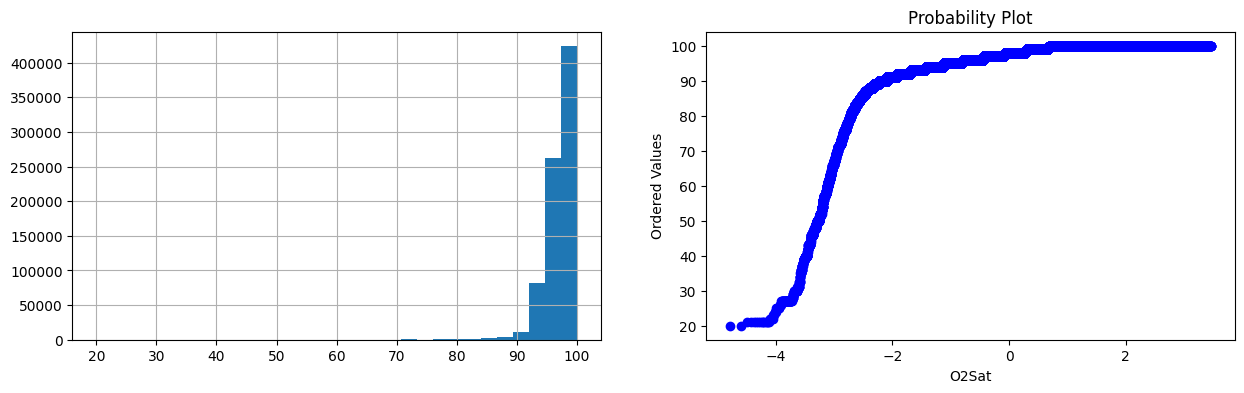

yeojohnson plot


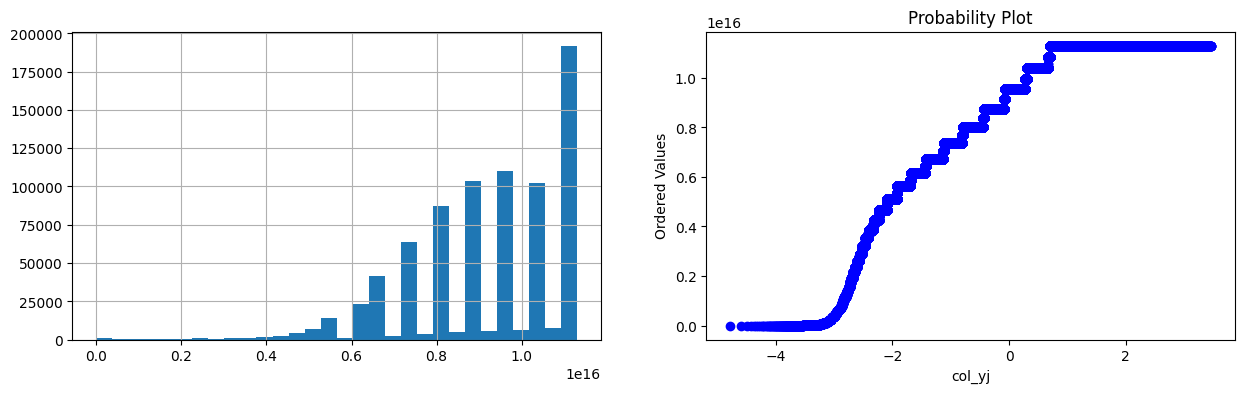

**1/1.5 plot


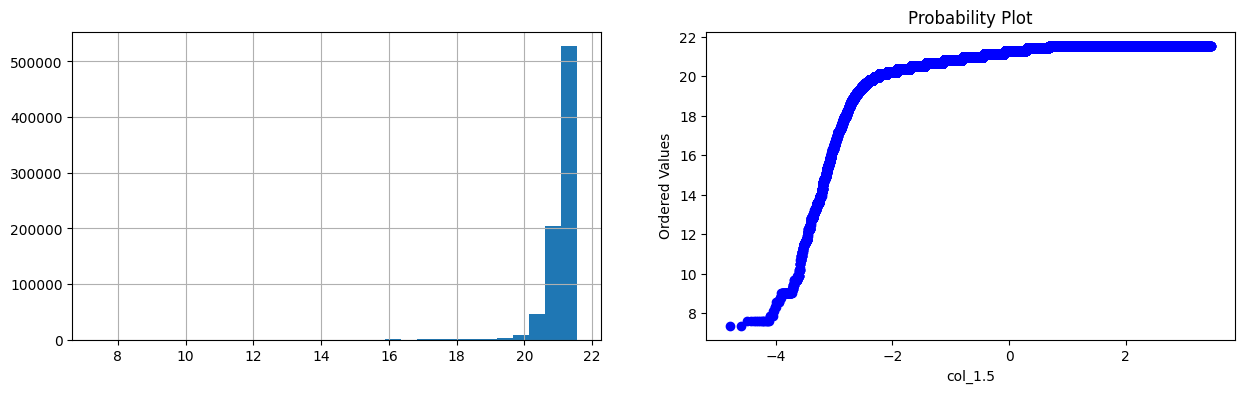

**.5 plot


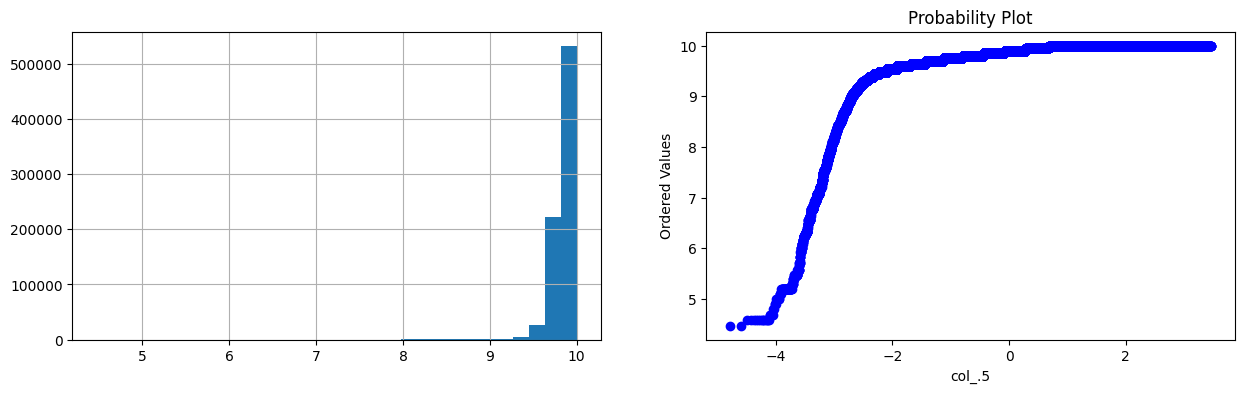

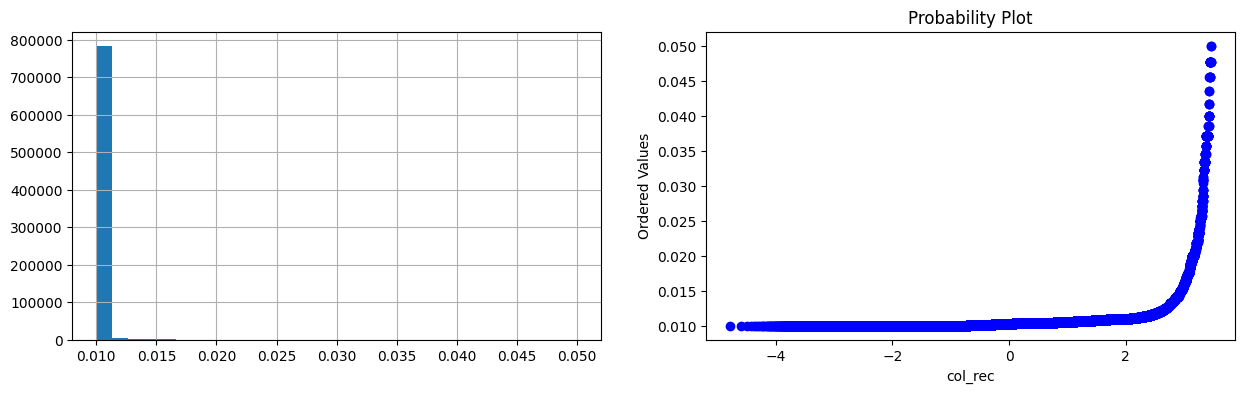

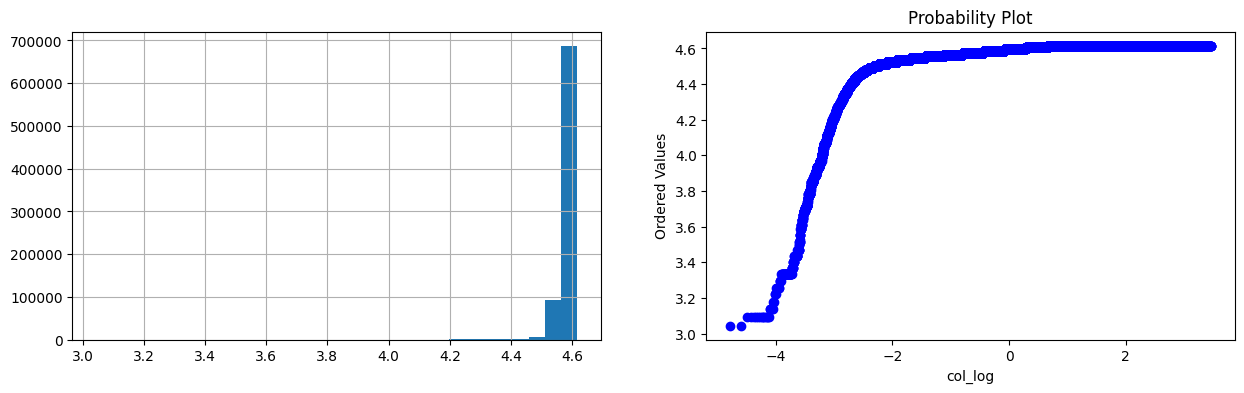

Temp
actual plot


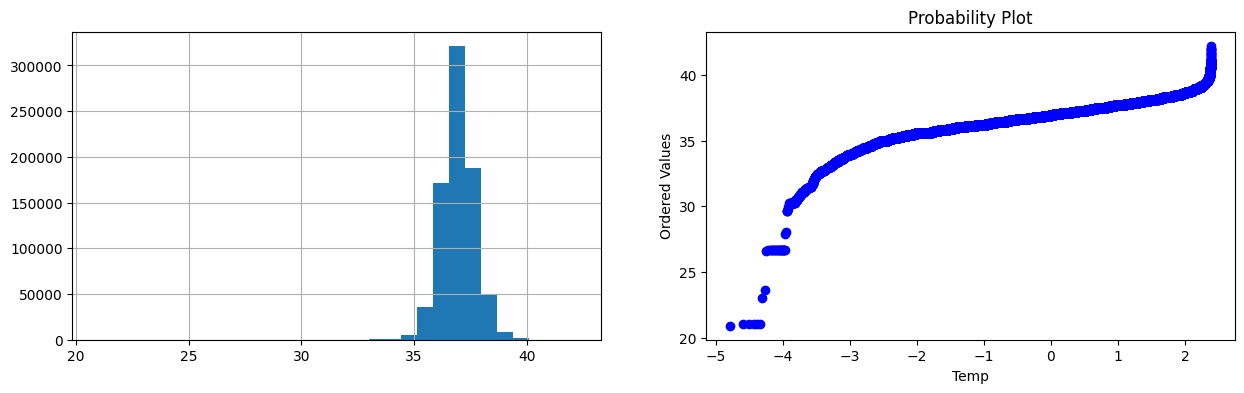

yeojohnson plot


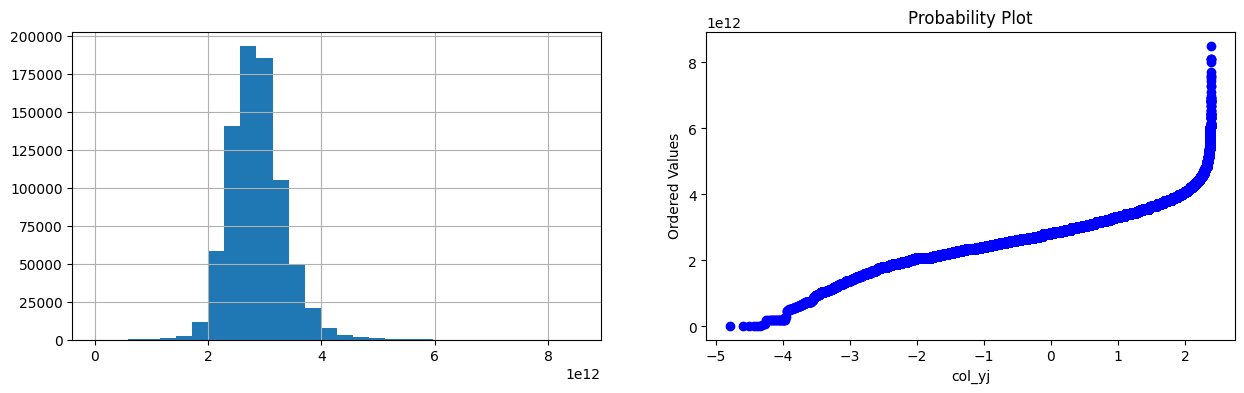

**1/1.5 plot


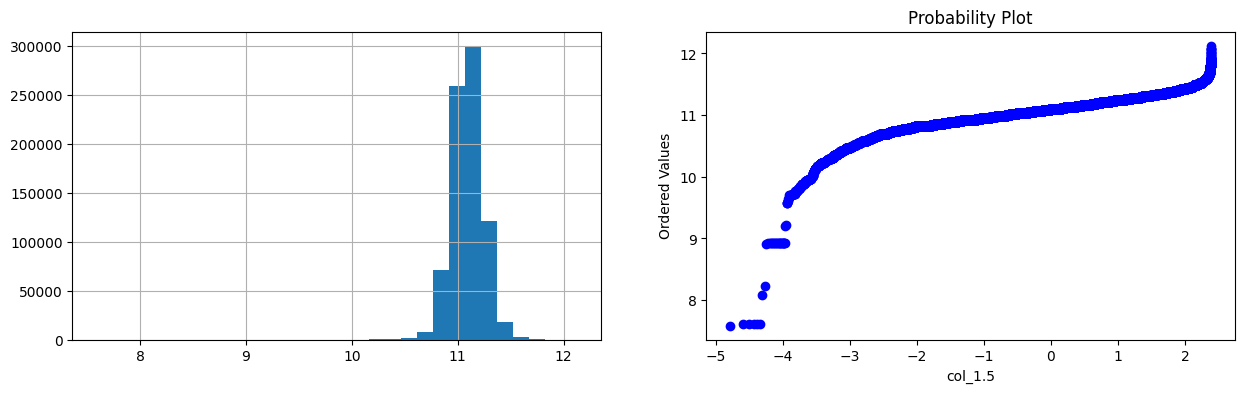

**.5 plot


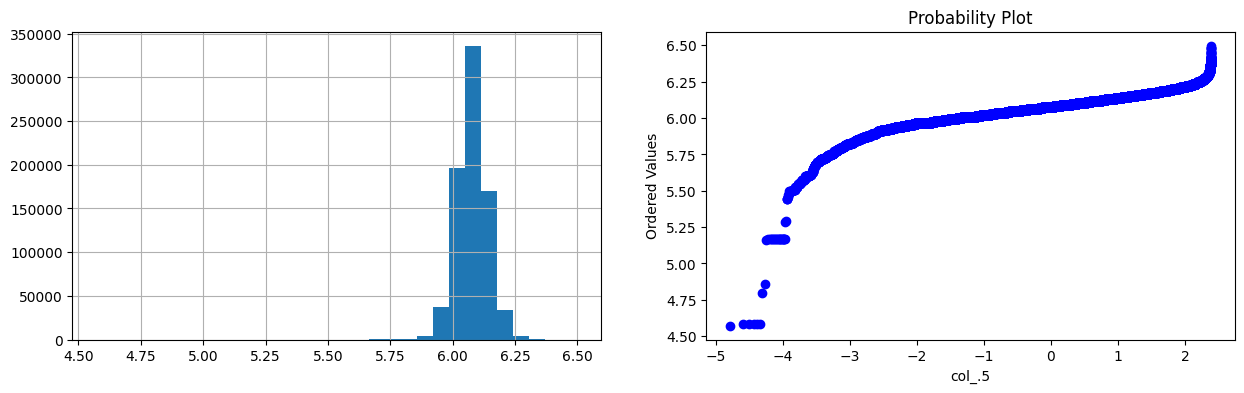

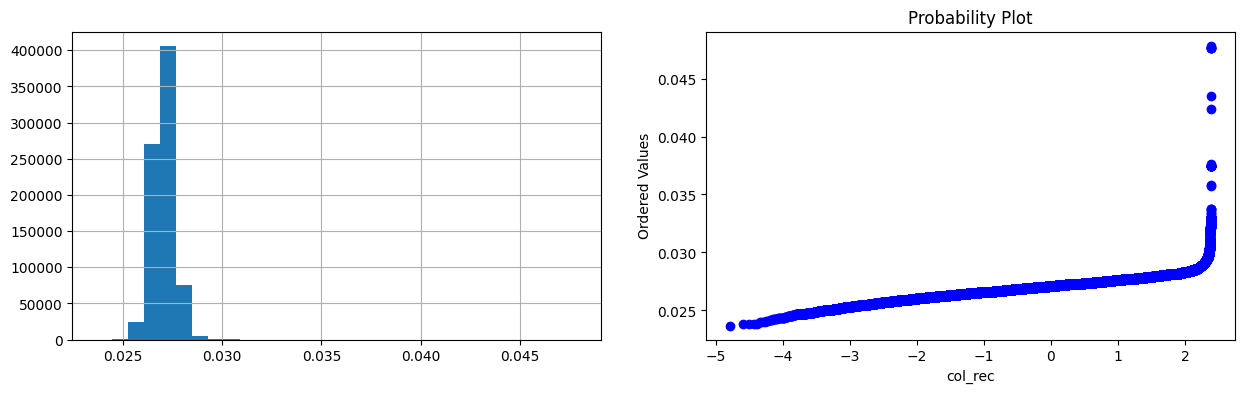

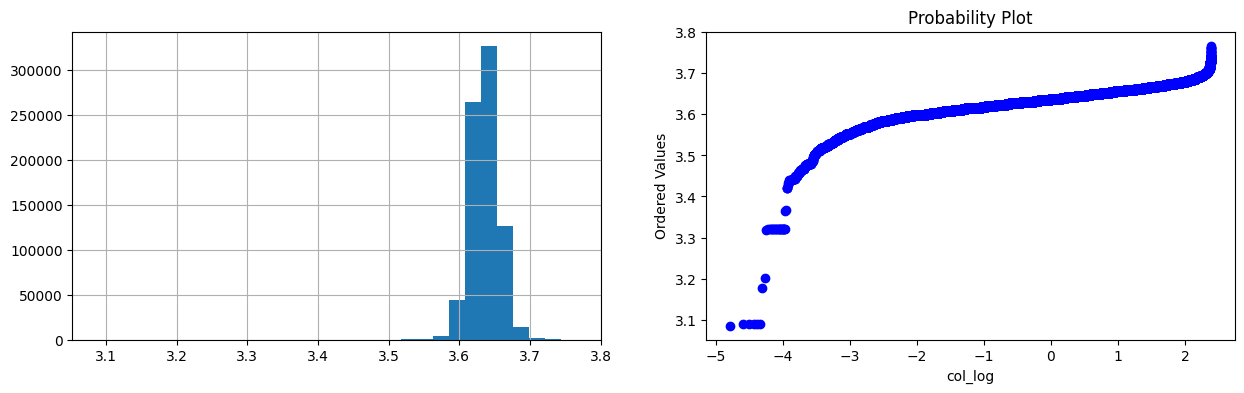

MAP
actual plot


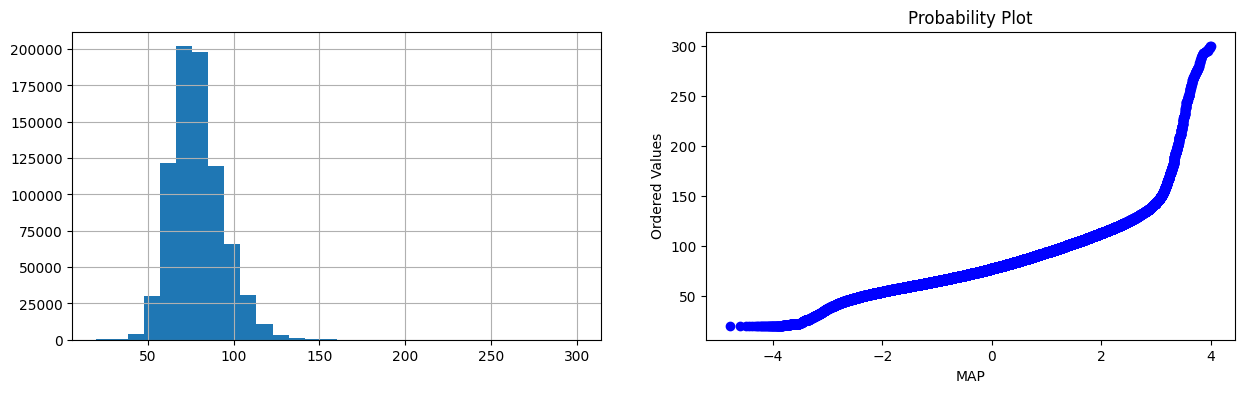

yeojohnson plot


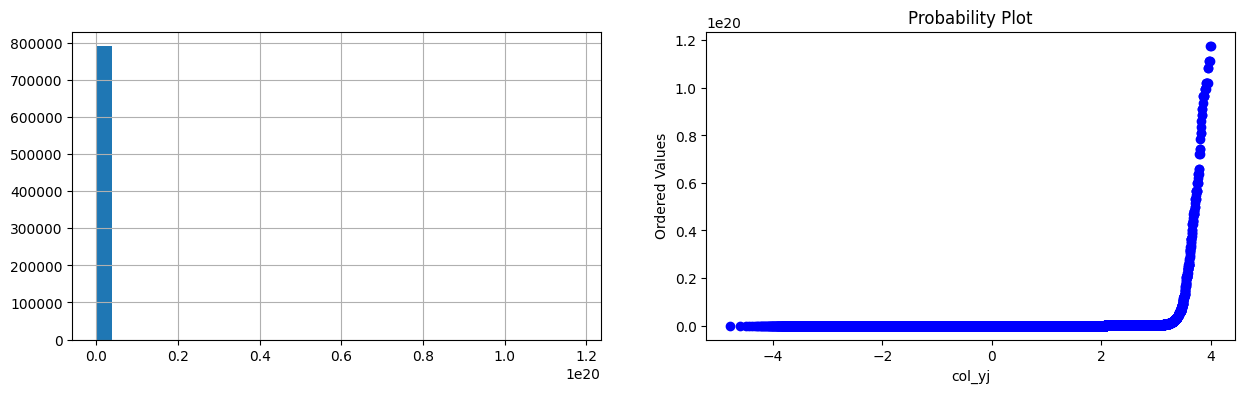

**1/1.5 plot


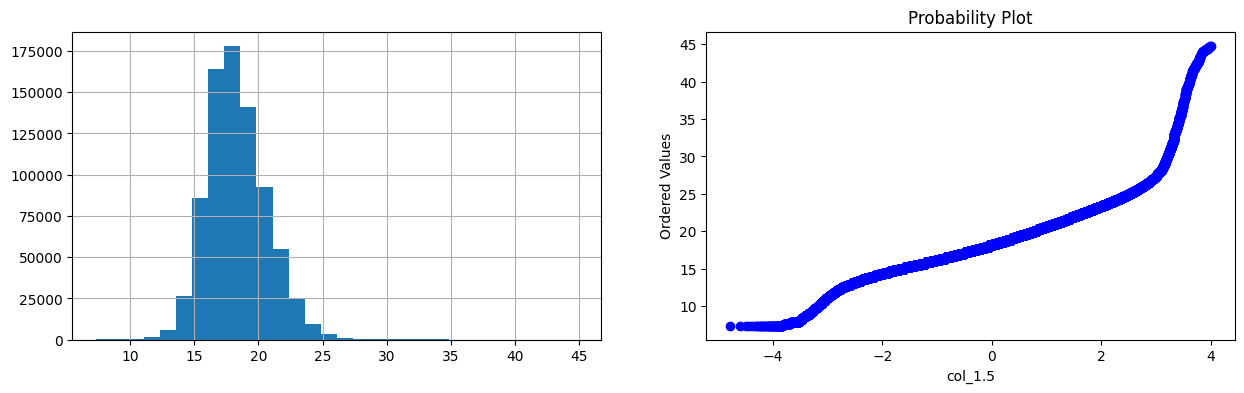

**.5 plot


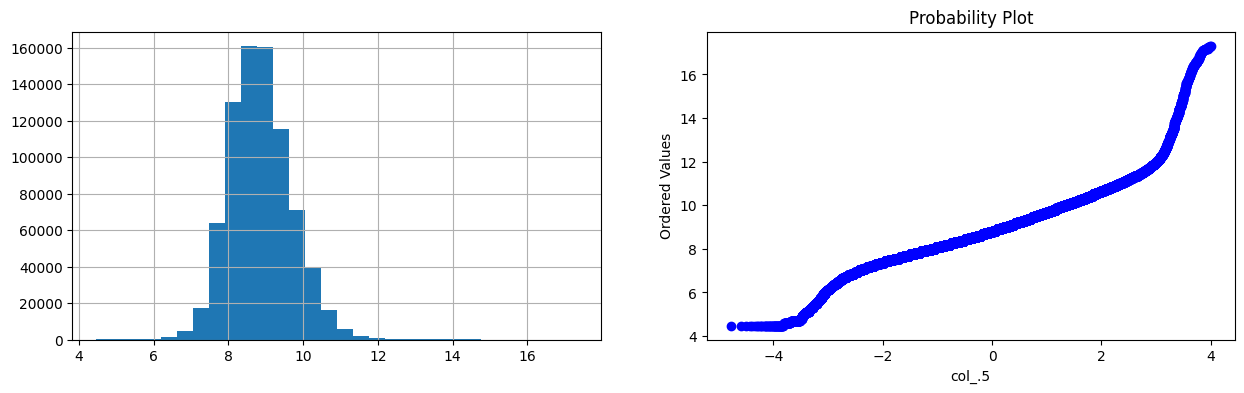

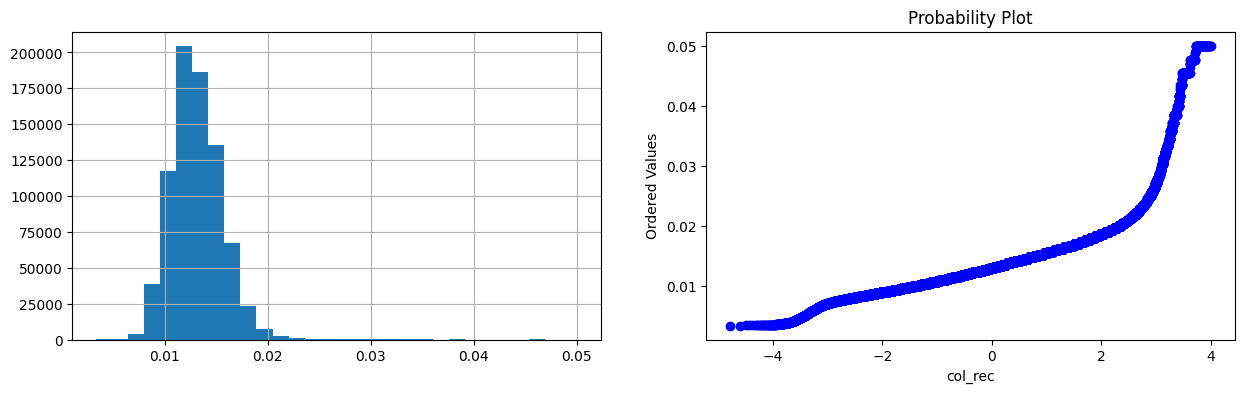

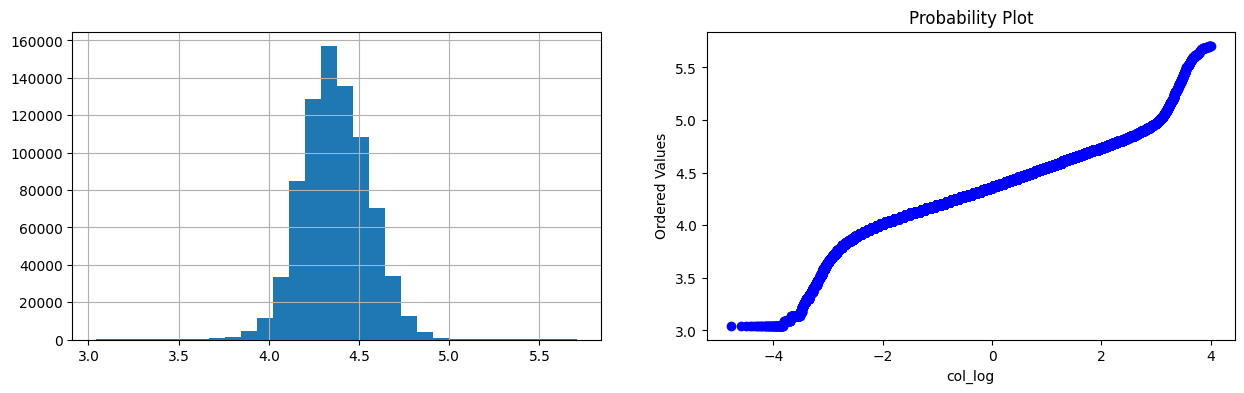

BUN
actual plot


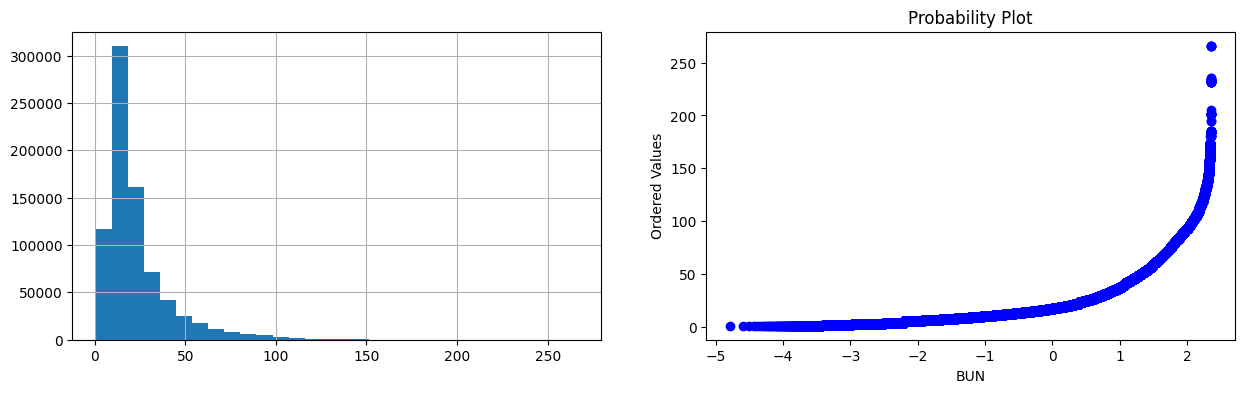

yeojohnson plot


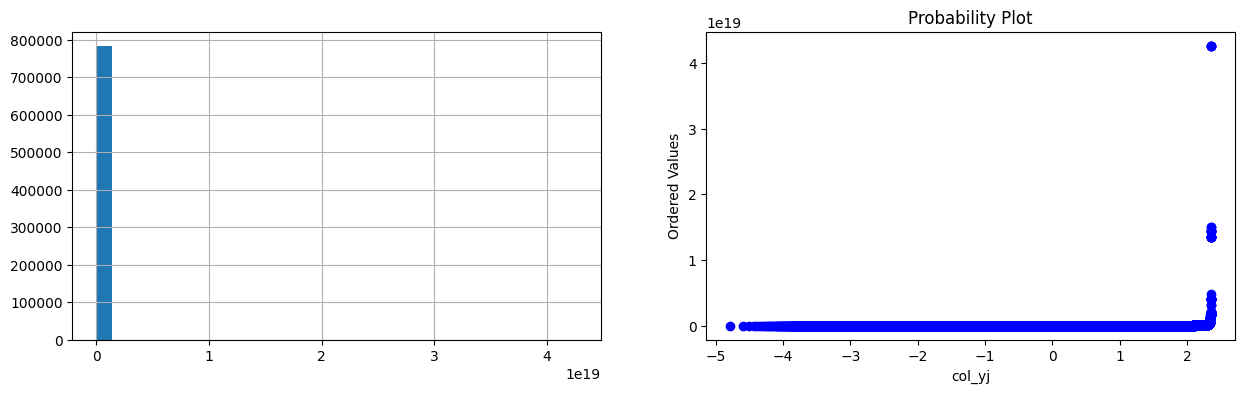

**1/1.5 plot


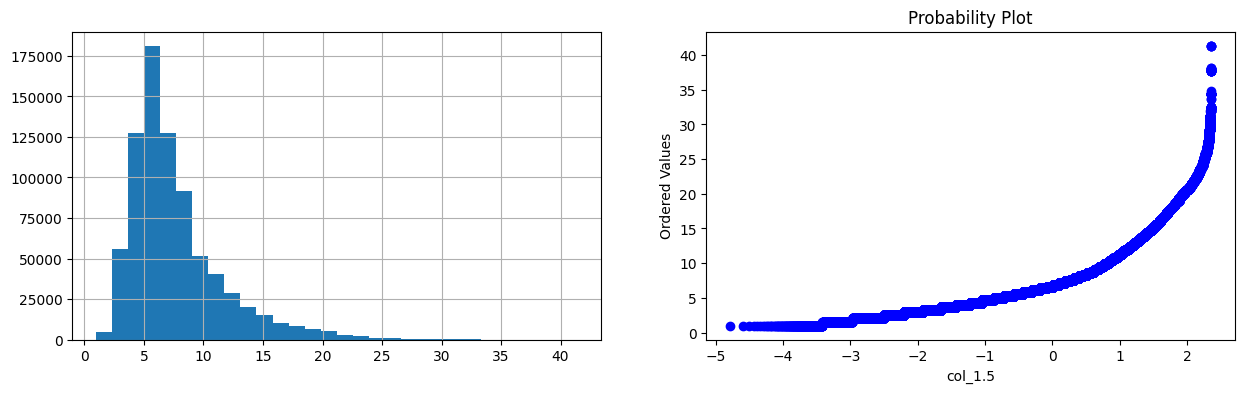

**.5 plot


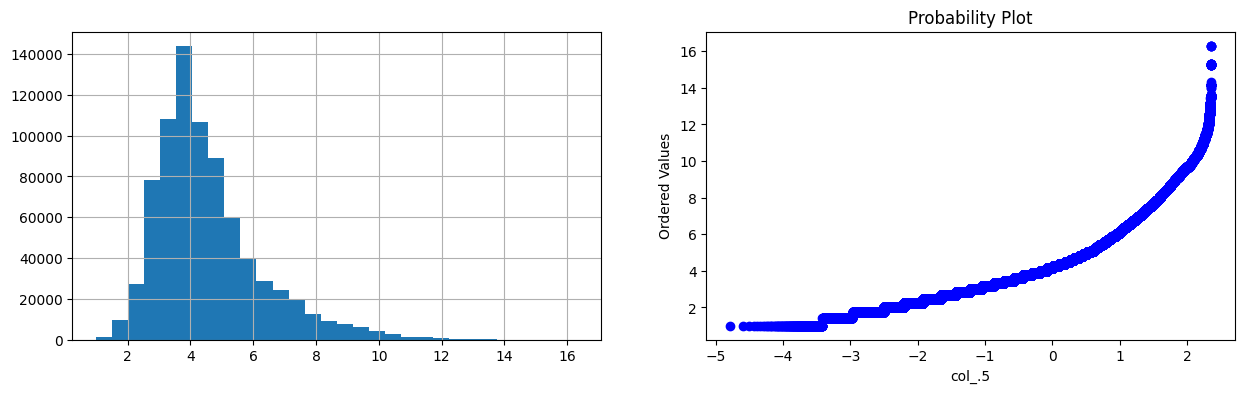

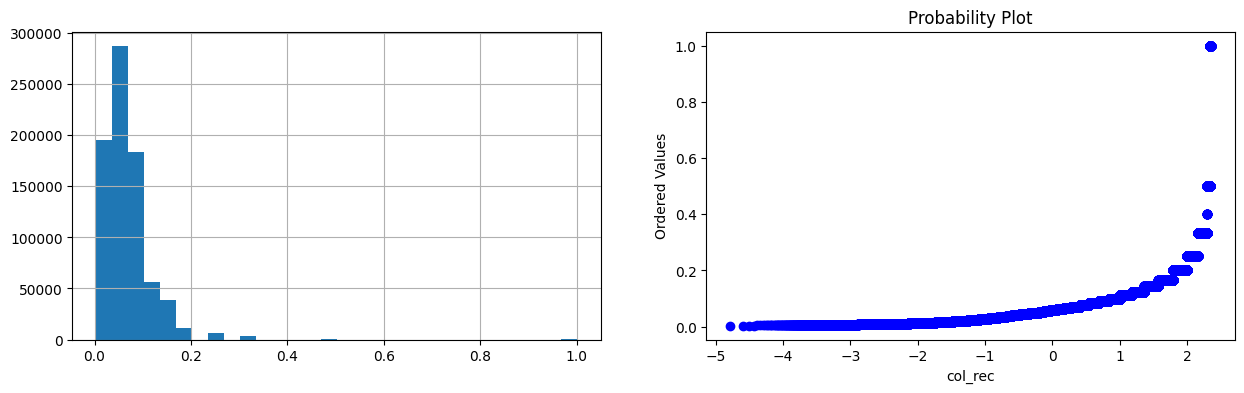

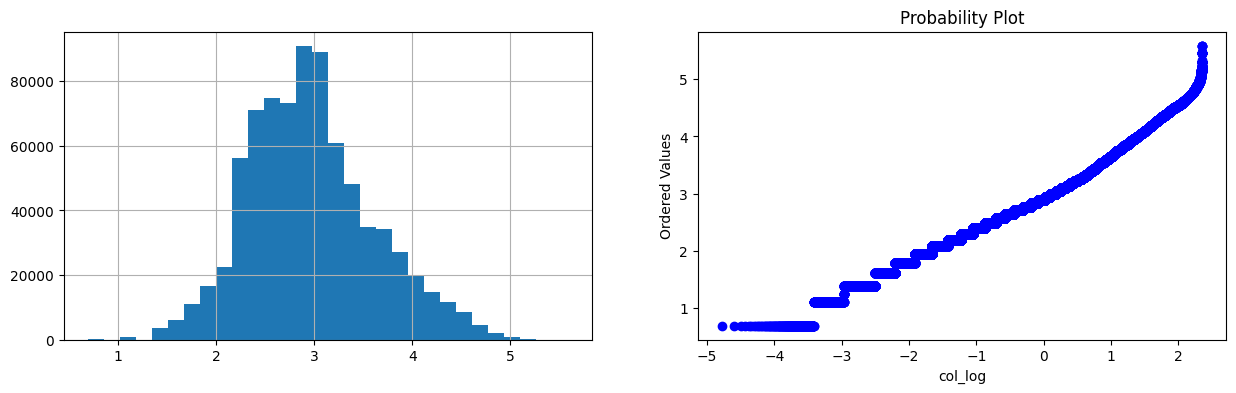

Creatinine
actual plot


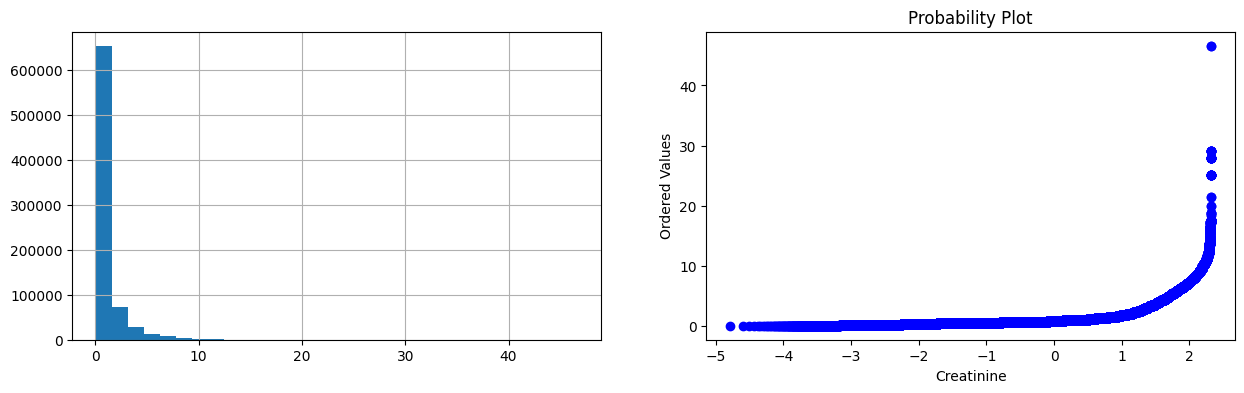

yeojohnson plot


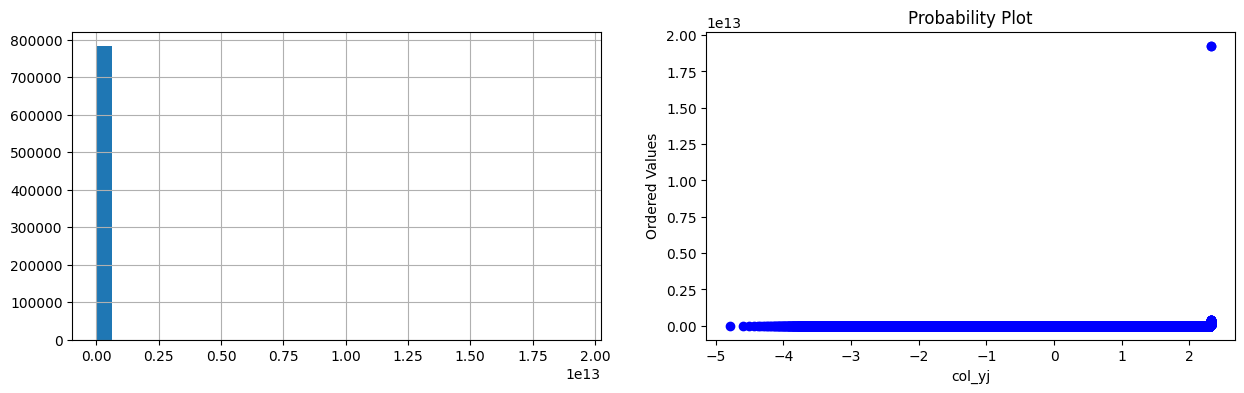

**1/1.5 plot


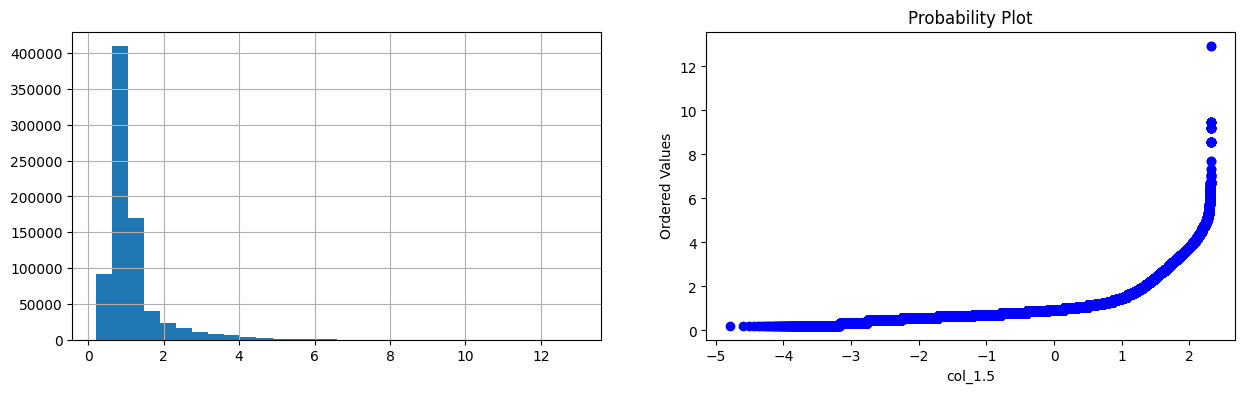

**.5 plot


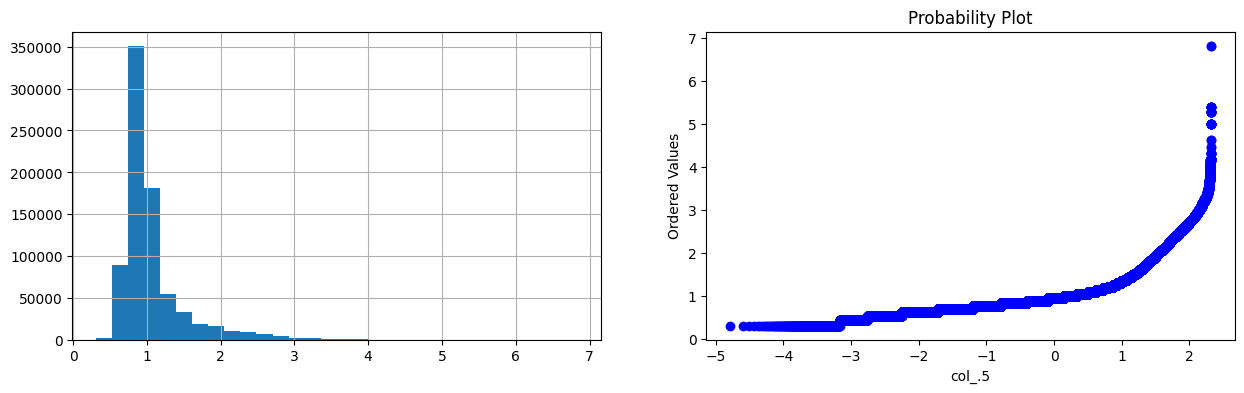

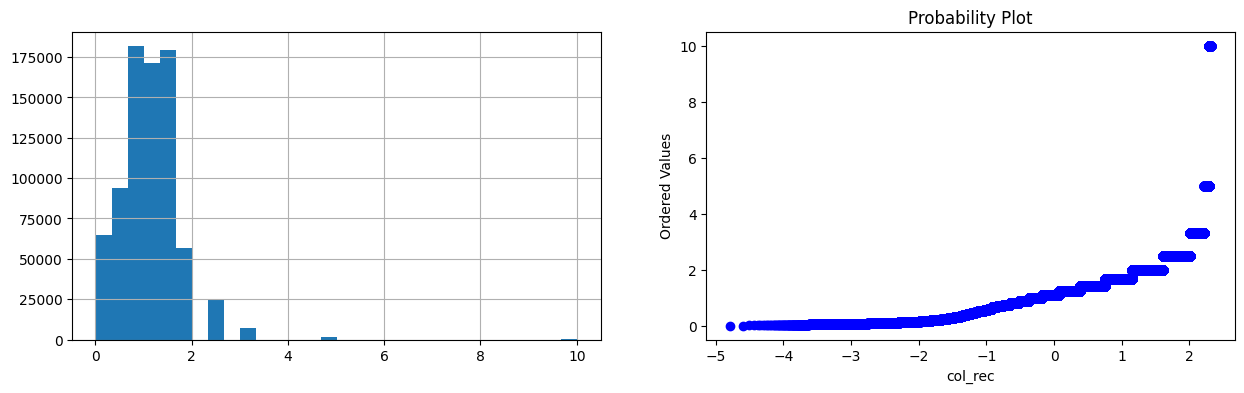

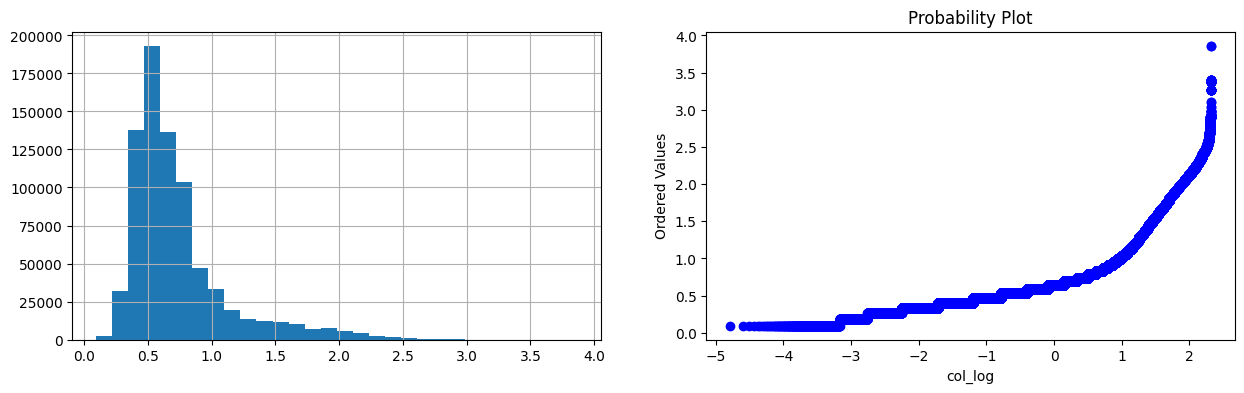

Glucose
actual plot


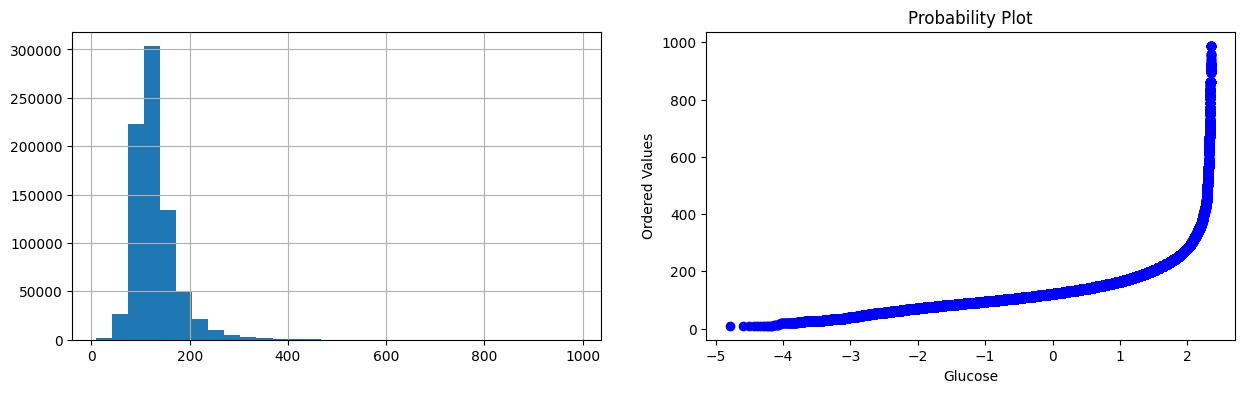

yeojohnson plot


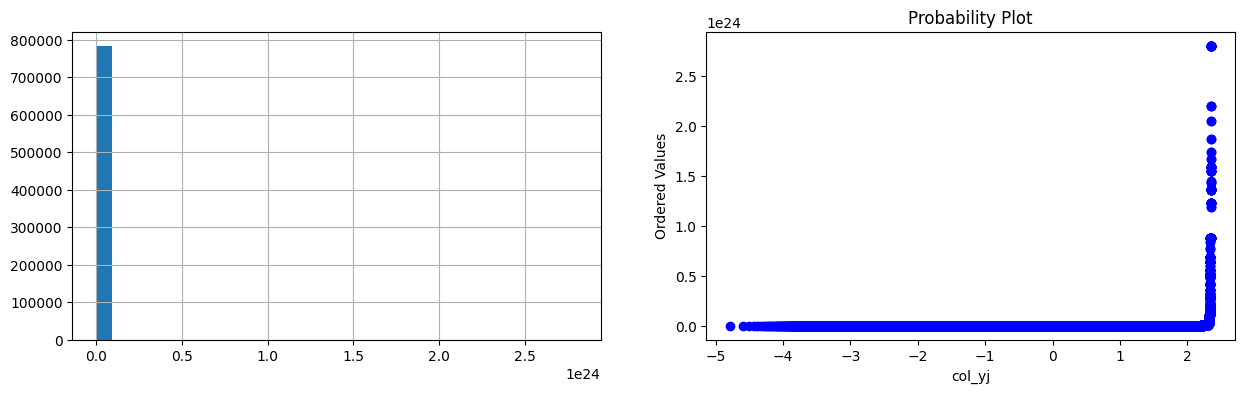

**1/1.5 plot


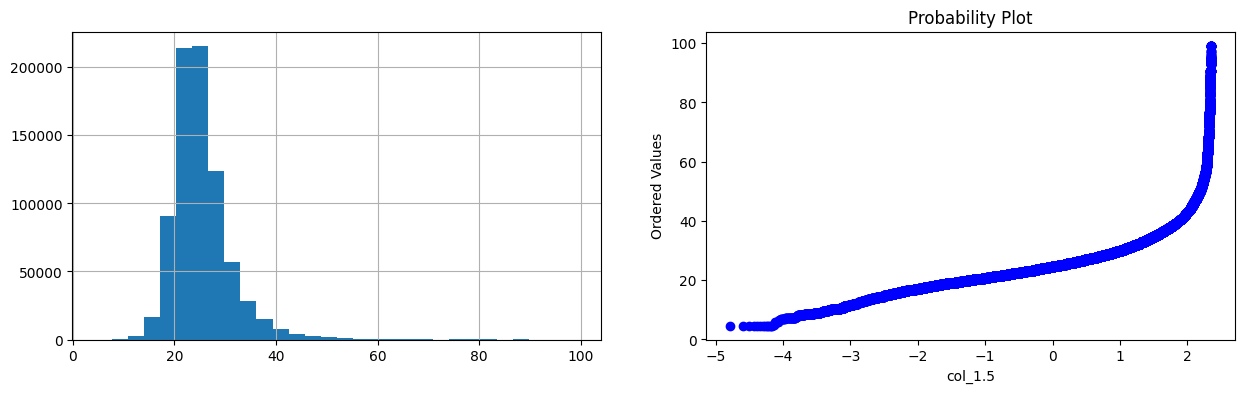

**.5 plot


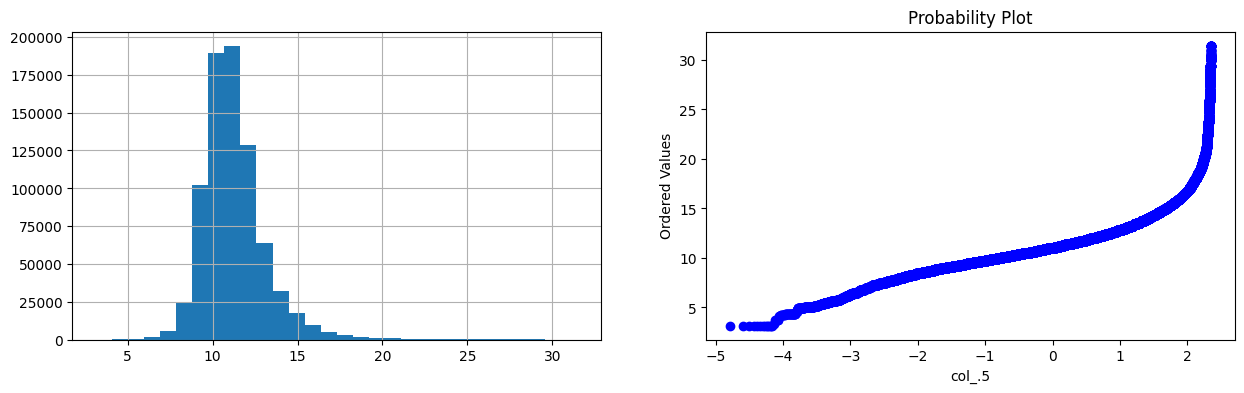

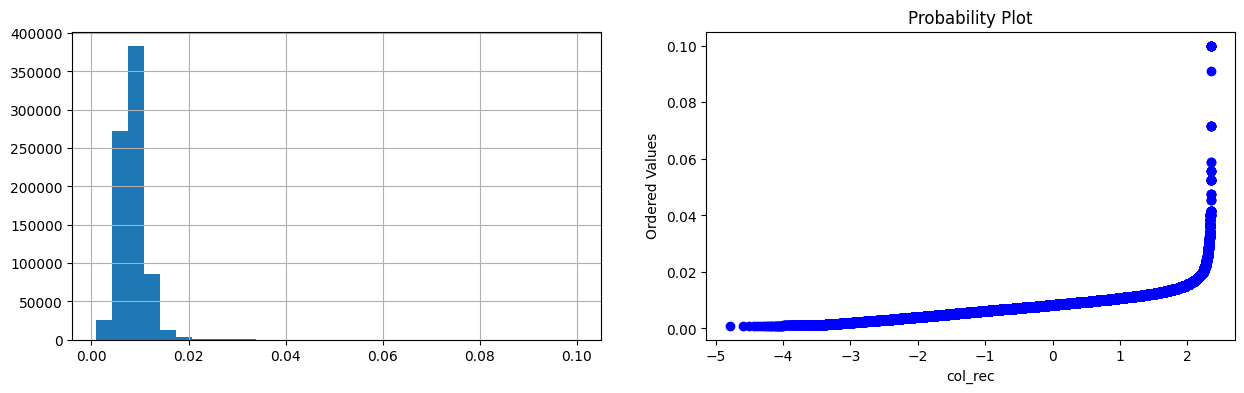

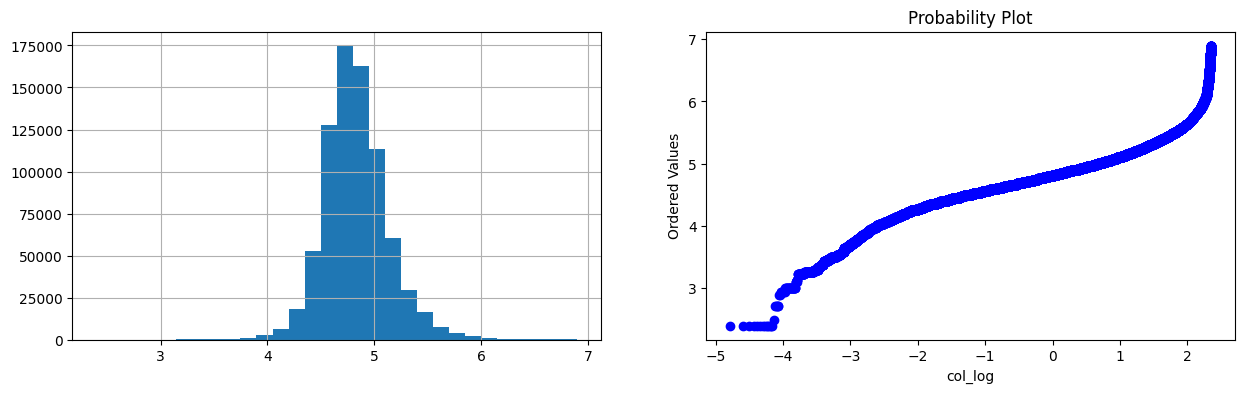

WBC
actual plot


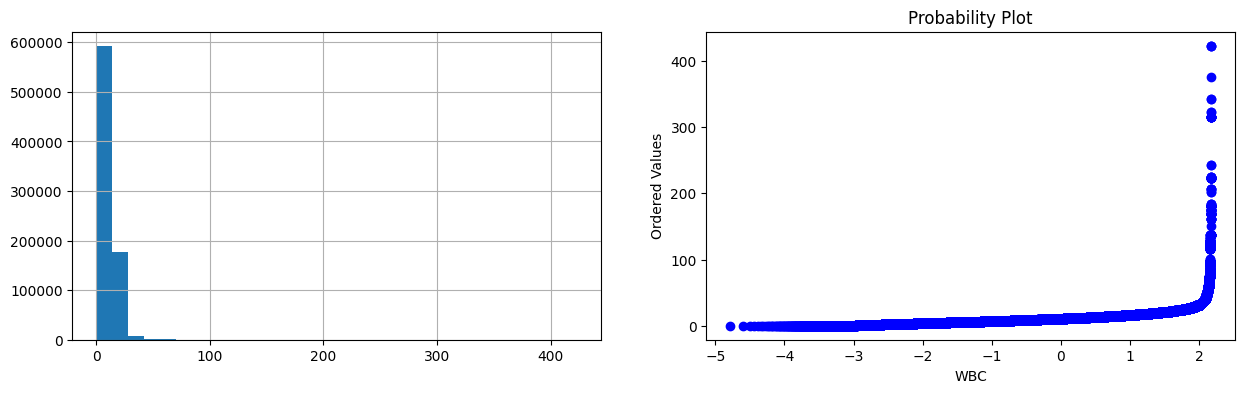

yeojohnson plot


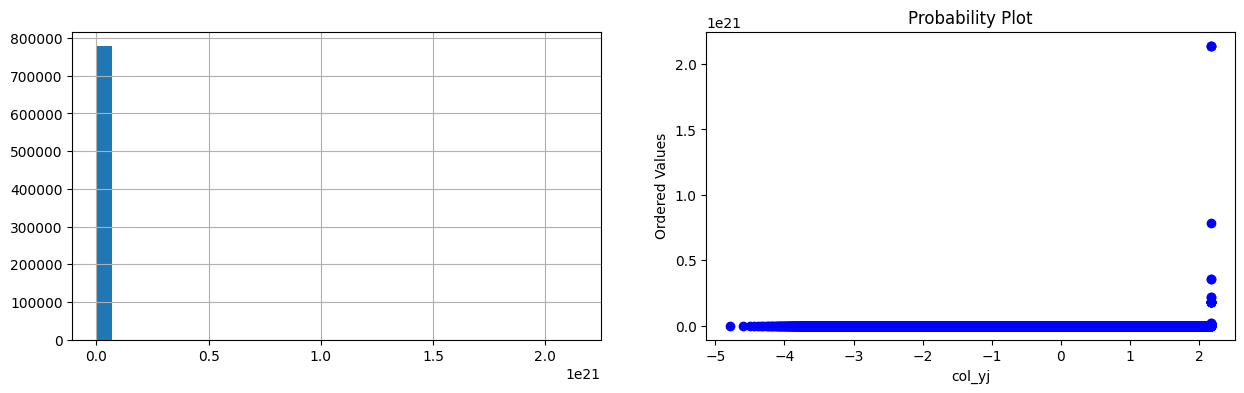

**1/1.5 plot


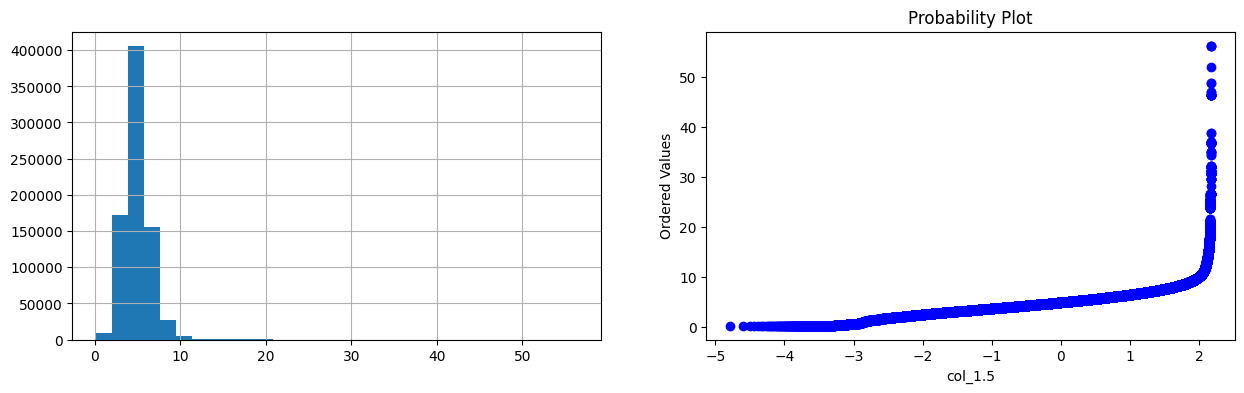

**.5 plot


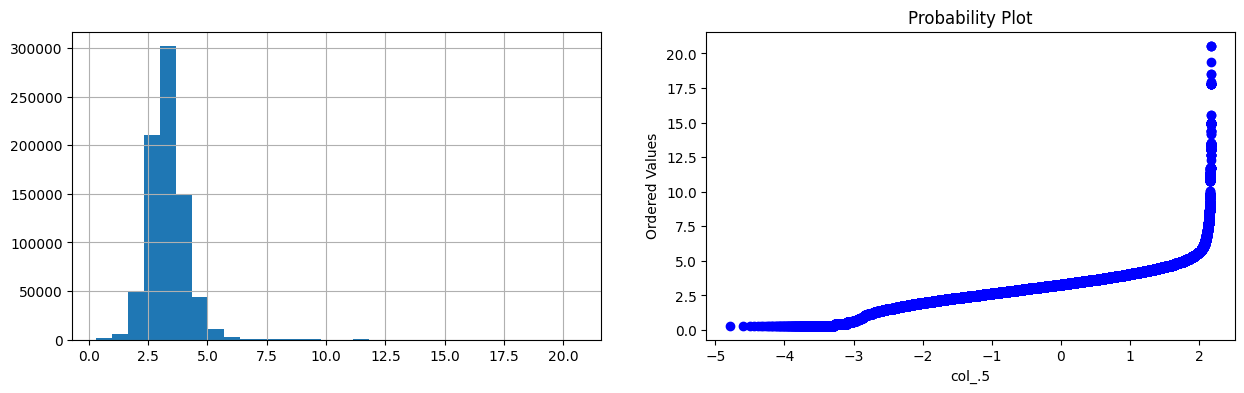

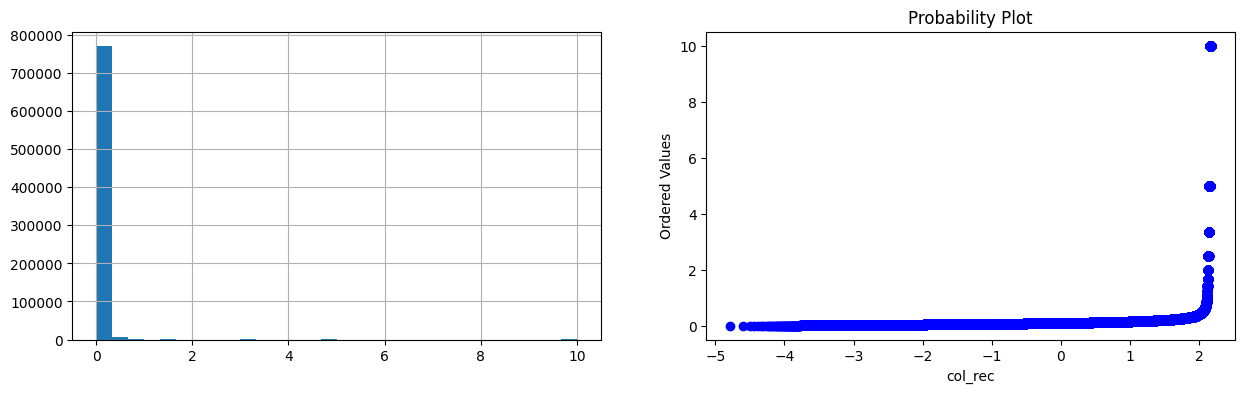

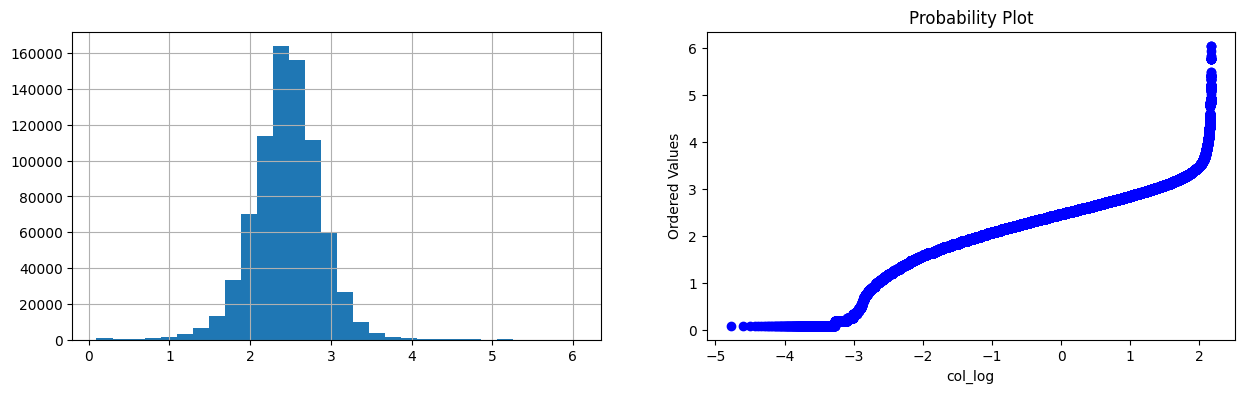

Platelets
actual plot


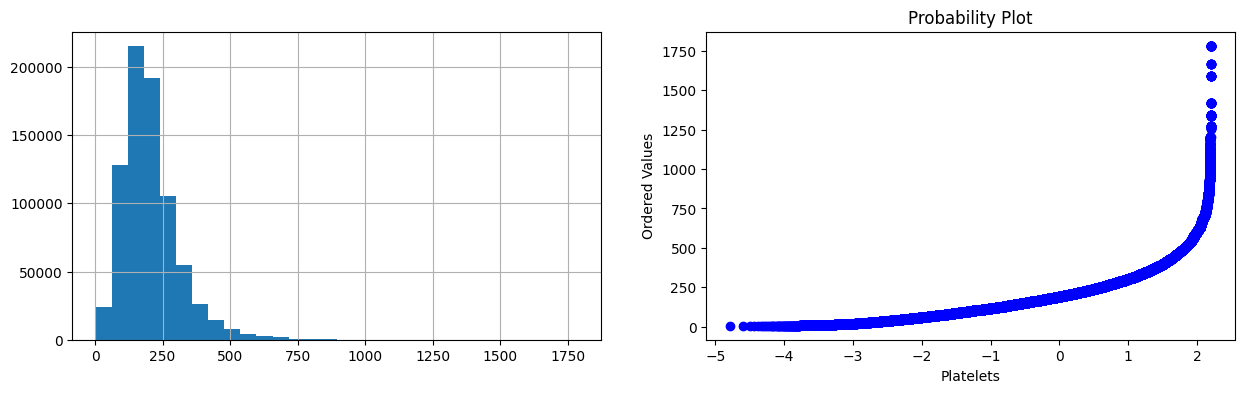

yeojohnson plot


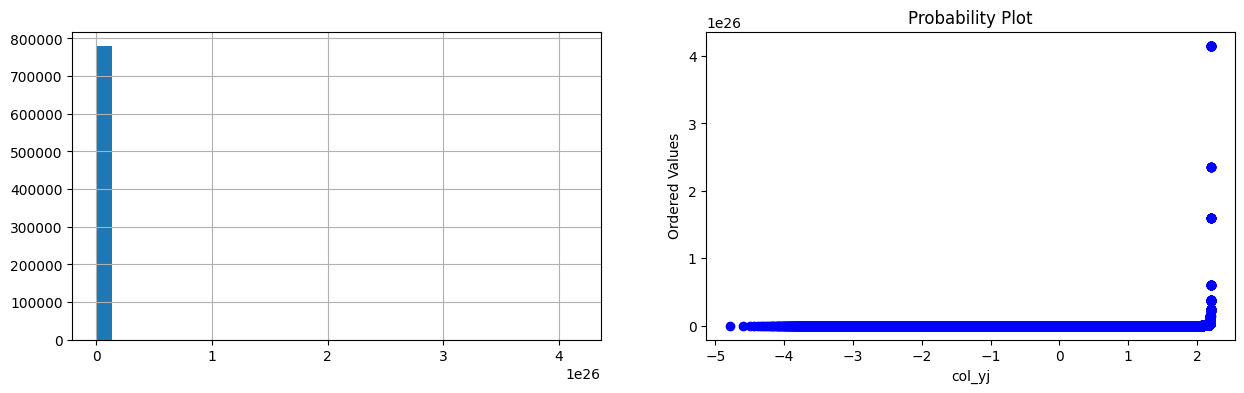

**1/1.5 plot


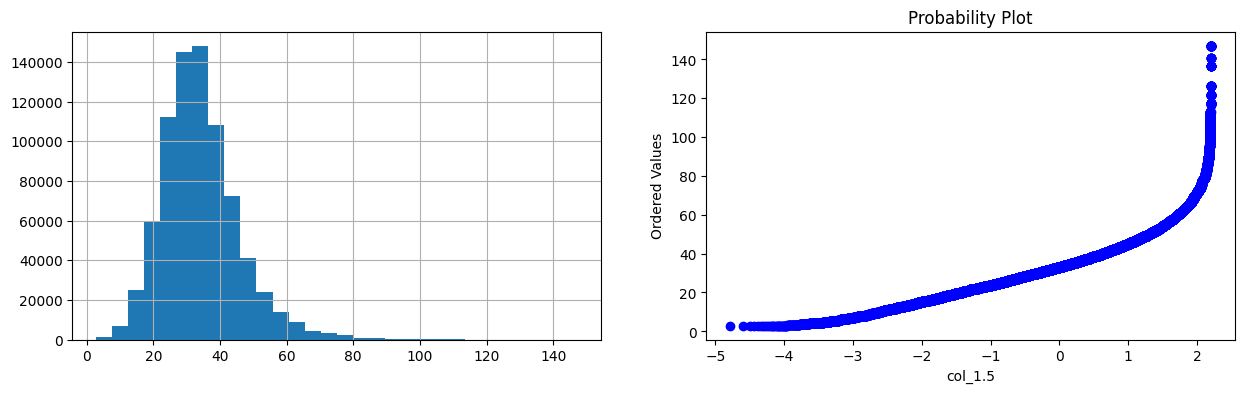

**.5 plot


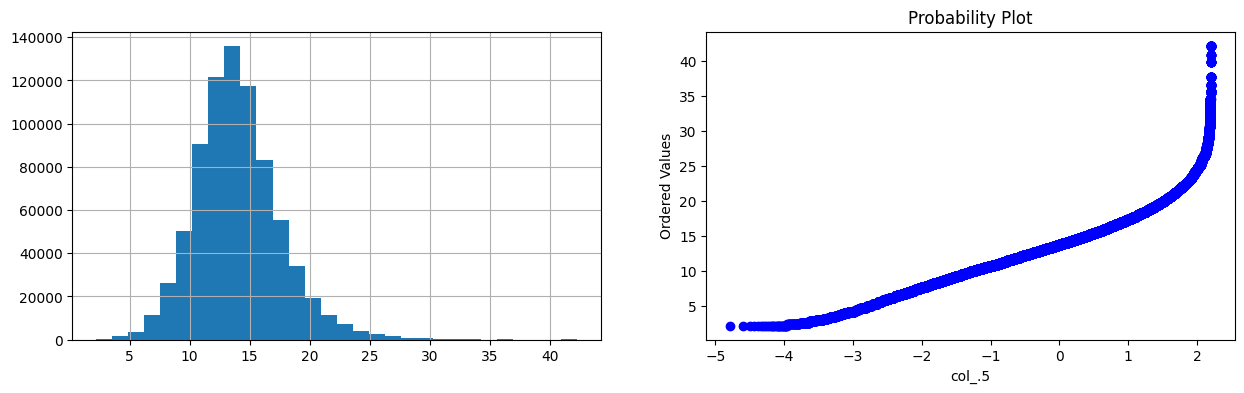

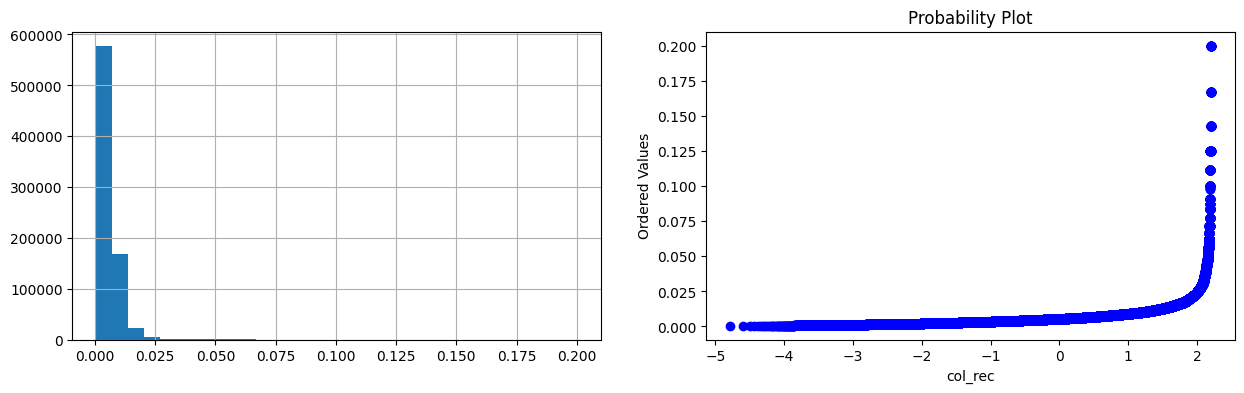

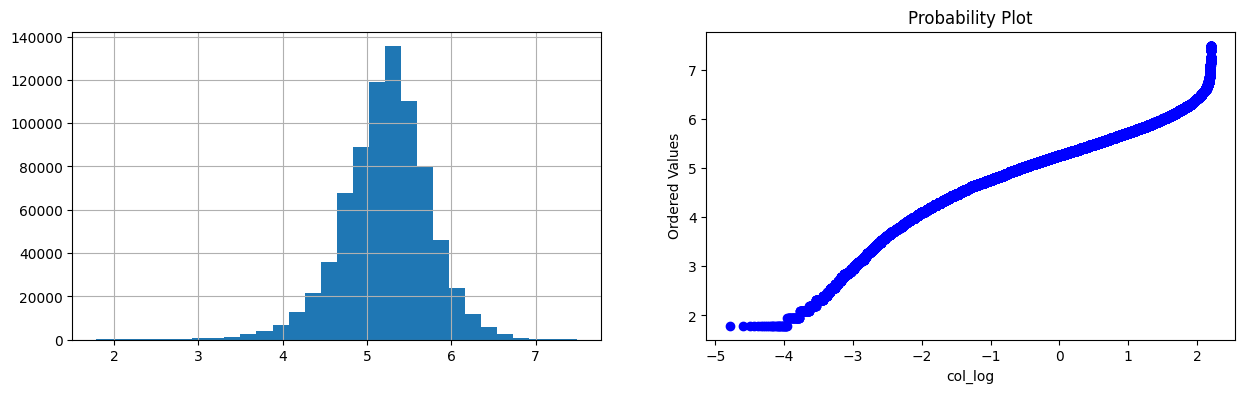

In [23]:
# try normal distribution
# Now we try to check the distribution of values present in different columns after application of various transformations

lst = ['O2Sat', 'Temp', 'MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in lst:
  print(i)
  try_gaussian(df_train_impute, i)

In [24]:
# after application of the above code, some redundant columns got added to the dataframe, which are removed through this line of code

df_train_impute = df_train_impute.drop(columns = ['col_yj','col_1.5','col_.5','col_rec','col_log'])


In [25]:
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
0,0,65.0,100.0,35.78,72.0,16.5,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,1,0,1,0
1,1,65.0,100.0,35.78,72.0,16.5,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,2,0,1,0
2,2,78.0,100.0,35.78,42.5,17.0,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,3,0,1,0
3,3,73.0,100.0,35.78,74.0,17.0,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,4,0,1,0
4,4,70.0,100.0,35.78,74.0,14.0,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,5,0,1,0


In [26]:
# by oserving different plots, it can be concluded that only log was somewhat effective and that too for MAP, BUN, Creatinine, Glucose, WBC & Plateletes
# therefore applying log transformations on the above columns

columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

In [27]:
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
0,0,65.0,100.0,35.78,4.290459,16.5,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,1,0,1,0
1,1,65.0,100.0,35.78,4.290459,16.5,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,2,0,1,0
2,2,78.0,100.0,35.78,3.772761,17.0,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,3,0,1,0
3,3,73.0,100.0,35.78,4.317488,17.0,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,4,0,1,0
4,4,70.0,100.0,35.78,4.317488,14.0,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,5,0,1,0


In [28]:
# standard normalization

scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
0,0,-1.170030,0.865243,-1.548869,-0.397650,-0.419685,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,1,0,1,0
1,1,-1.170030,0.865243,-1.548869,-0.397650,-0.419685,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,2,0,1,0
2,2,-0.407913,0.865243,-1.548869,-3.187955,-0.326969,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,3,0,1,0
3,3,-0.701035,0.865243,-1.548869,-0.251970,-0.326969,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,4,0,1,0
4,4,-0.876908,0.865243,-1.548869,-0.251970,-0.883265,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,5,0,1,0


In [29]:
df_train_impute = df_train_impute.dropna()

In [30]:
null_values = df_train_impute.isnull().mean()*100
null_values

Hour           0.0
HR             0.0
O2Sat          0.0
Temp           0.0
MAP            0.0
Resp           0.0
BUN            0.0
Chloride       0.0
Creatinine     0.0
Glucose        0.0
Hct            0.0
Hgb            0.0
WBC            0.0
Platelets      0.0
Age            0.0
HospAdmTime    0.0
ICULOS         0.0
SepsisLabel    0.0
0              0.0
1              0.0
dtype: float64

In [31]:
# this function will transform the dataframe (for final testing) in the compatible 
# format for the input of the model
# this will make it easier to get the dataframe ready in a single go for prediction

def get_data_ready(df):
  columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
  df = df.assign(Unit=df['Unit1'] + df['Unit2'])
  
  # dropping columns based on redundancy
  df = df.drop(columns=columns_drop)
  grouped_by_patient = df.groupby('Patient_ID')

  # imputing backfill and forward fill
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())

  # dropping all the columns with null values more than 25% and patient_id
  null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2','Unit', 'Patient_ID']
  df = df.drop(columns=null_col)
    
  # gaussian transformation
  columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
  for i in columns_normalized:
    df[i] = np.log(df[i]+1)
    
  # normailizing
  scaler = StandardScaler()
  df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])

  # onehot encoding the gender
  one_hot = pd.get_dummies(df['Gender'])
  df = df.join(one_hot)
  df = df.drop('Gender', axis=1)
  df = df.dropna()
  return df

# Model Building

In [32]:
# this fucntion calculates different evaluation parameters of a model

def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()

In [33]:
# checking the distribution of data points between the two classes

majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

number of sepsis label 1 is 15284
while number of sepsis label 0 is 750935


So, this shows a clear imbalance between sepsis label 1 and label 0, to deal with this, we did undersampling.

In [34]:
# Undersampling

majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

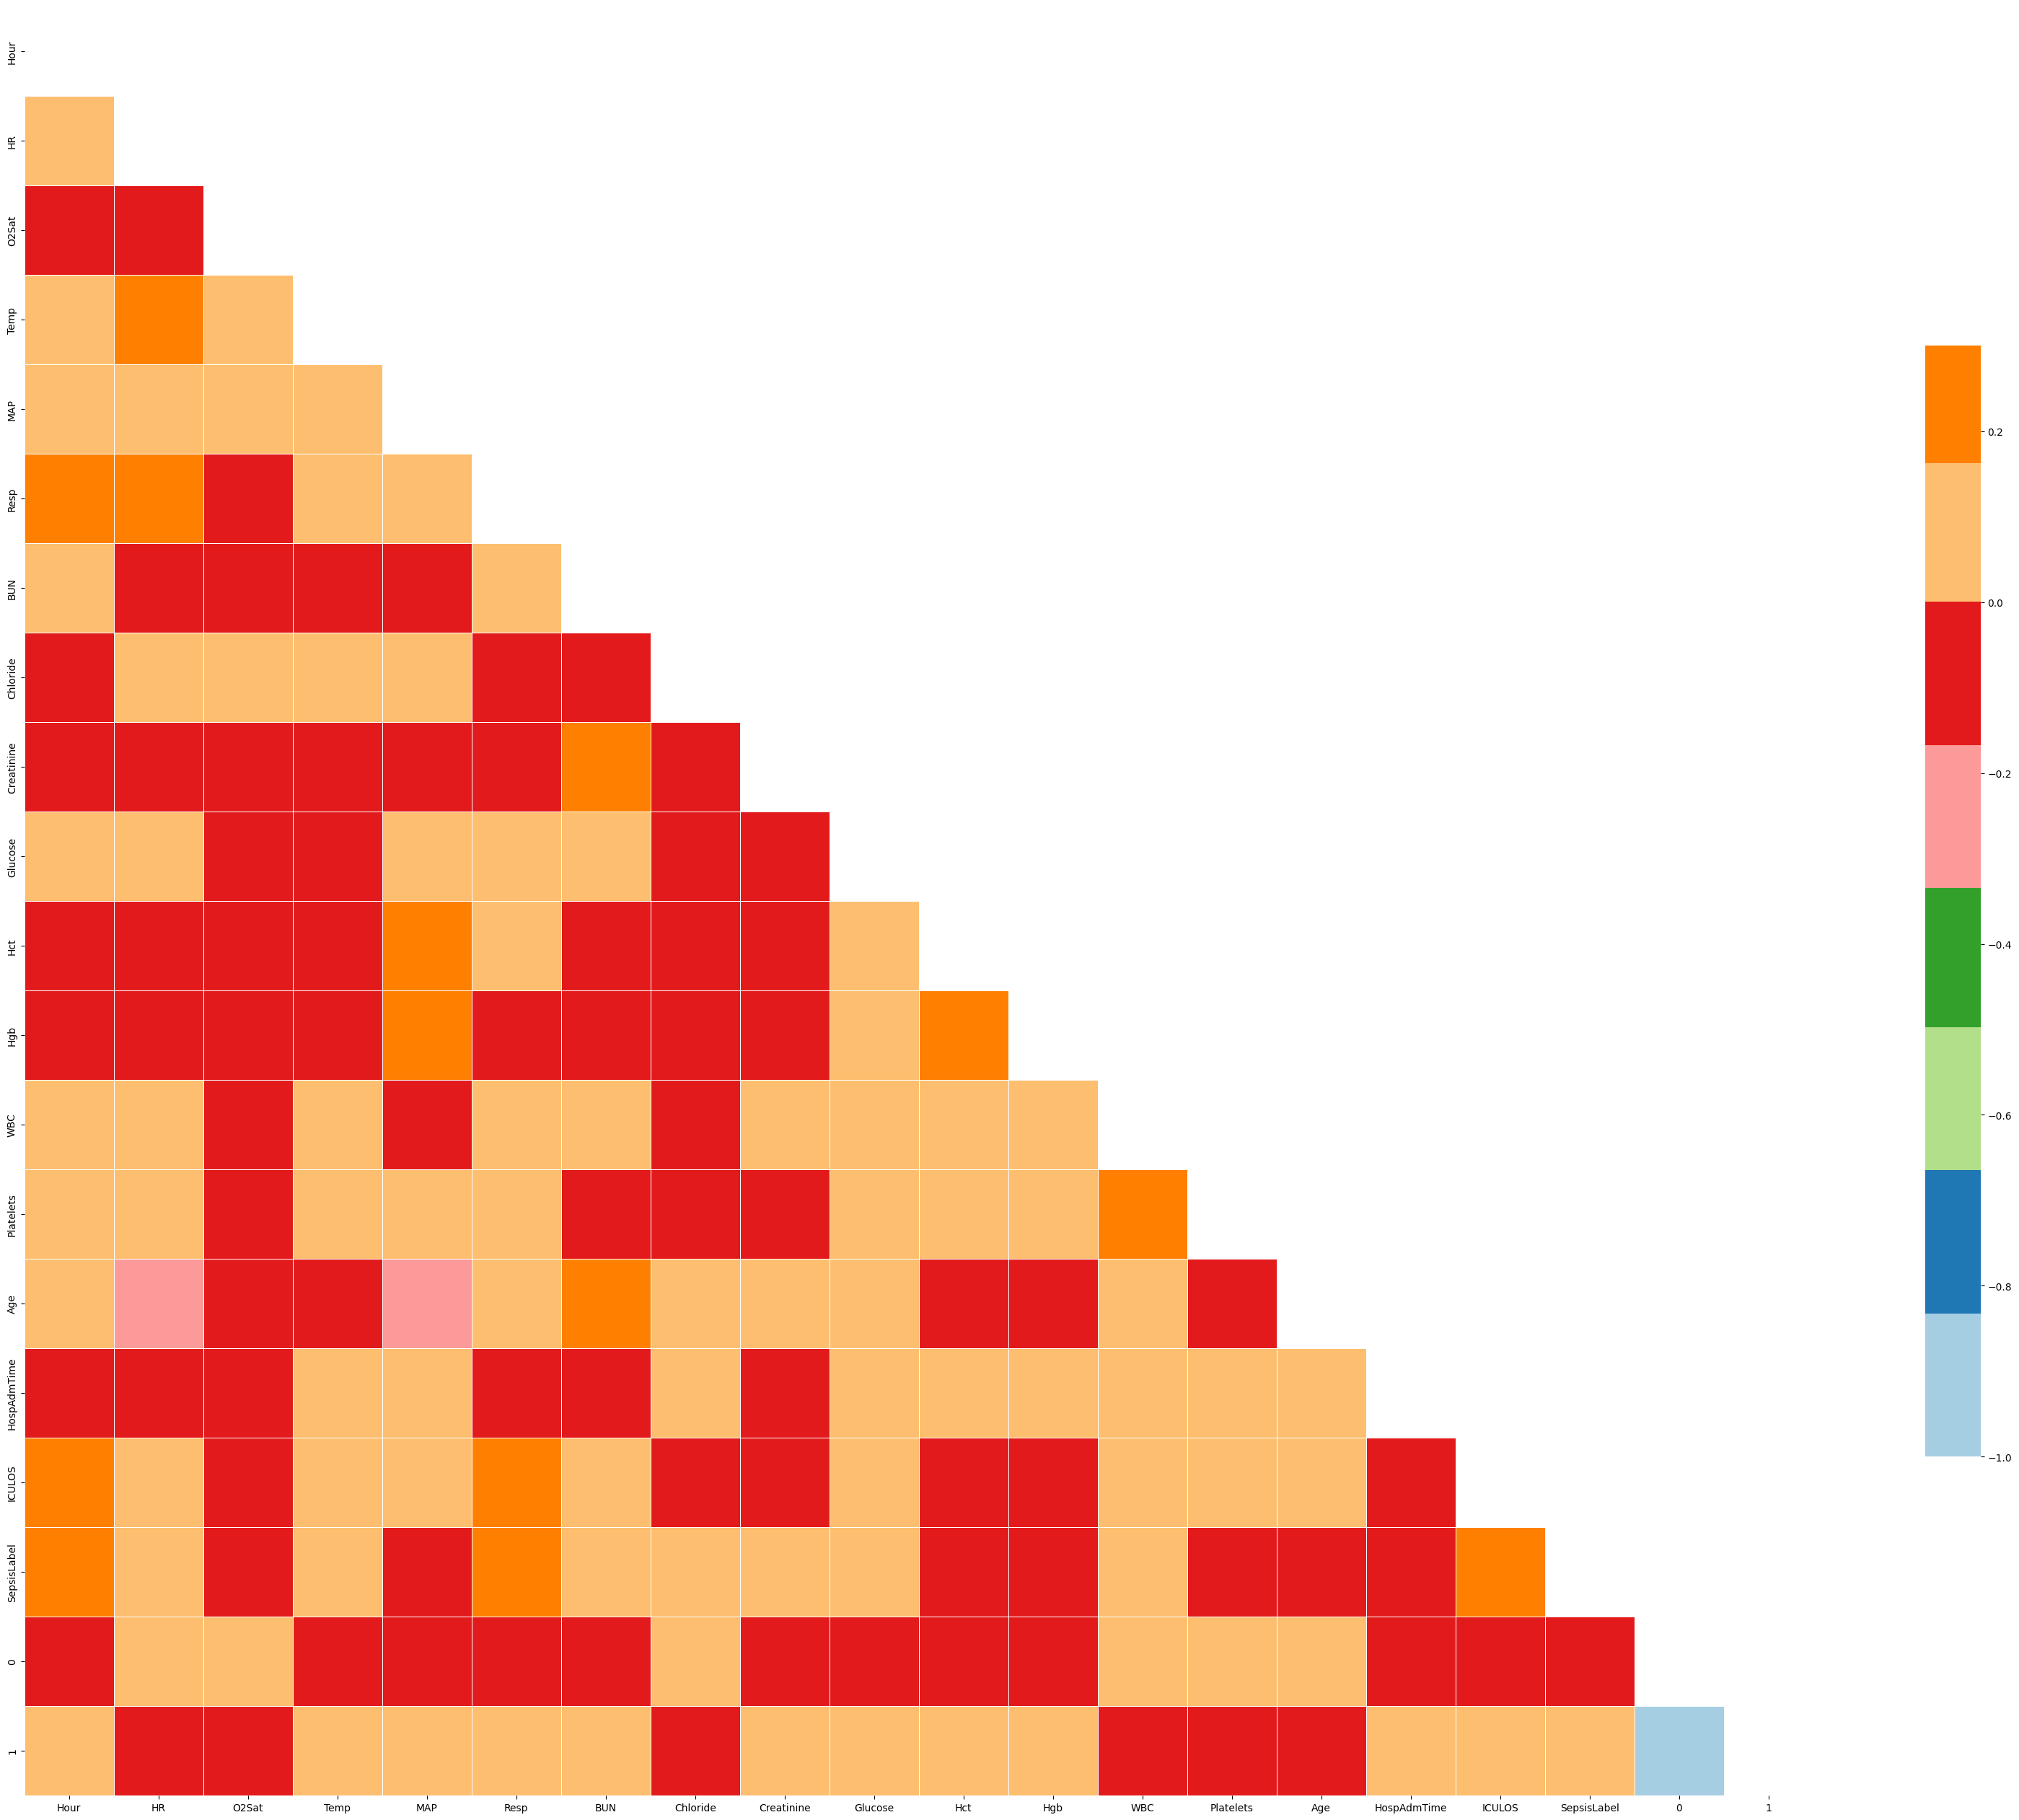

In [35]:
corr_matrix(df_train_impute)

In [36]:
# train test split for the imputed output
X = df_train_impute.drop('SepsisLabel', axis=1)
y = df_train_impute['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
X_train.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,0,1
101000,10,-0.319977,-0.065399,0.612658,-1.106824,0.414760,-0.042867,-0.226541,-0.007482,-0.723147,-0.413974,-0.593624,-0.225016,-0.581846,69.87,-24.41,11,0,1
21661,18,0.236955,-0.065399,0.532105,1.134416,0.600192,0.037457,-0.043880,-0.410796,-0.181831,-0.064238,0.054438,-0.072181,-0.792348,74.79,-0.02,19,0,1
750434,83,-0.026855,-0.996040,-0.058623,-0.623830,1.156488,-0.042867,1.052085,-0.410796,0.209533,-0.269965,-0.181221,0.280753,0.862228,67.43,-0.03,84,0,1
425913,50,0.002457,-0.065399,0.223315,-1.106824,-1.439562,-0.762476,-0.957185,-0.887815,1.376041,0.162062,0.113353,1.154371,0.077241,67.49,-59.80,53,1,0
445282,38,0.764574,-0.685827,0.089059,-0.324318,0.229328,-0.042867,-0.774524,-0.410796,0.209533,-0.434547,-0.475794,0.742680,0.261510,84.86,-46.44,39,0,1


In [38]:
X_test

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,0,1
393088,24,-1.052781,0.865243,0.532105,-0.940970,-1.254130,0.256318,0.321441,-0.410796,-0.822764,-1.627765,-1.477344,-1.085830,0.097477,59.86,-0.02,26,0,1
407852,16,0.705950,0.244815,-1.629423,-0.251970,-0.697833,-0.042867,-0.774524,-0.135134,-1.664014,0.162062,-0.181221,1.393779,-0.581846,71.03,-19.37,20,1,0
274600,4,1.409442,0.865243,0.089059,0.294302,-0.512401,-1.212974,1.600067,-0.410796,0.772865,-0.866574,-0.947112,0.387604,0.639018,57.99,1.82,8,0,1
706236,62,-0.466537,-0.065399,0.840894,0.730711,-0.697833,0.564359,-1.322507,-0.135134,0.109662,3.371408,2.764515,-1.021823,-1.046311,67.61,-0.03,63,0,1
35465,38,-0.056167,-1.616468,-0.206305,-1.149097,1.341920,-1.047984,0.686763,-0.269336,-1.412312,0.244353,0.290097,0.651000,0.684257,60.76,-0.03,40,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470239,79,0.881823,-0.375613,0.679787,-0.547377,-1.624994,0.773464,0.504102,3.323059,-0.890903,-0.866574,-1.123856,-0.270558,-0.484535,30.07,-1417.86,80,1,0
772922,33,3.168174,0.244815,-0.958141,-0.422070,1.527353,-0.217041,-1.322507,-0.887815,-0.323434,-0.331683,-0.299050,1.359375,1.870608,68.19,-0.02,35,1,0
127249,14,-1.932147,-0.685827,-0.958141,0.629761,-0.697833,-0.127534,-0.226541,-0.269336,0.159979,1.540435,1.821880,0.298900,1.128928,69.99,-0.02,15,0,1
392208,146,-0.407913,0.555029,1.431622,0.965089,0.414760,-0.898732,0.321441,-0.887815,-0.960490,1.478717,1.409477,0.801886,-0.353427,67.87,-2.62,149,1,0


In [39]:
y_test

393088    0
407852    0
274600    0
706236    1
35465     1
         ..
470239    1
772922    0
127249    0
392208    1
175447    1
Name: SepsisLabel, Length: 9171, dtype: int64

In [40]:
y_train

101000    0
21661     0
750434    1
425913    0
445282    0
         ..
364733    0
279135    0
499766    1
142494    0
27679     0
Name: SepsisLabel, Length: 36681, dtype: int64

#using cross validation to choose hyperparams
from sklearn.model_selection import train_test_split, GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50,100,200,300],
    'max_depth': [5,10,15,None],
    'min_samples_split': [2,4,8],
    'min_samples_leaf': [1,2,4],
    'max_features': ['log2','sqrt',None]
}
# Initialize the classifier
clf = RandomForestClassifier(random_state=42,n_jobs=-1)

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Make predictions on the test set using the best classifier
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluate the model performance
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.9583469632537346
Precision: 0.9239580019090041
Recall: 0.9530685920577617
F1 Score: 0.9382875605815831
AUC-ROC: 0.957020906087666
Mean Absolute Error: 0.0416530367462654
Root Mean Squared Error: 0.2040907561509472


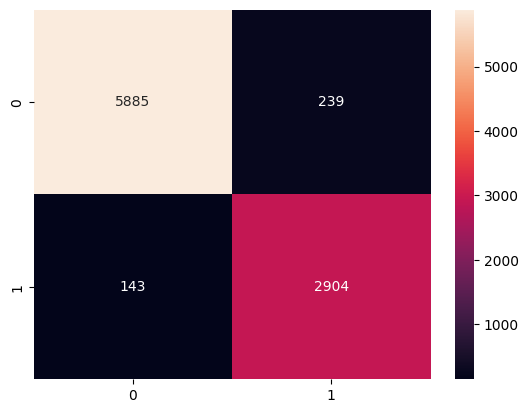

In [69]:
#Random Forest

model = RandomForestClassifier(n_estimators=300, criterion='gini',random_state=42)
model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)
evaluate_model(y_test,rcf_predictions)

# Testing other hospital data

In [46]:
#other data
df = get_data_ready(df_test)
X = df.drop('SepsisLabel', axis=1)
y = df['SepsisLabel']

In [65]:
y_train

101000    0
21661     0
750434    1
425913    0
445282    0
         ..
364733    0
279135    0
499766    1
142494    0
27679     0
Name: SepsisLabel, Length: 36681, dtype: int64

In [62]:
X

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,0,1
1052,0,-0.161964,-0.690100,-0.848113,2.521990,1.726149,0.327125,-1.085879,3.289937,-1.173035,-0.821316,-0.926468,-0.493650,0.026787,52.0,-8.78,1,0,1
1053,1,-0.161964,-0.690100,-0.848113,2.521990,1.726149,0.327125,-1.085879,3.289937,-1.173035,-0.821316,-0.926468,-0.493650,0.026787,52.0,-8.78,2,0,1
1054,2,-0.274790,0.622151,-0.848113,1.991875,2.134170,0.327125,-1.085879,3.289937,-1.173035,-0.821316,-0.926468,-0.493650,0.026787,52.0,-8.78,3,0,1
1055,3,-0.218377,-0.690100,-0.272485,0.464756,1.930159,0.327125,-1.085879,3.289937,-1.173035,-0.821316,-0.926468,-0.493650,0.026787,52.0,-8.78,4,0,1
1056,4,-0.387616,0.950214,-0.272485,1.498325,1.114117,0.327125,-1.085879,3.289937,-1.173035,-0.821316,-0.926468,-0.493650,0.026787,52.0,-8.78,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761836,51,-0.444029,0.294088,0.303144,-1.594904,-0.109946,2.868481,-1.459354,1.351776,0.567479,0.044612,-0.204598,-1.275756,-0.831089,62.0,-3.19,52,1,0
761837,52,-0.387616,0.130057,0.303144,-1.191861,-0.211951,2.868481,-1.459354,1.351776,0.567479,0.044612,-0.204598,-1.275756,-0.831089,62.0,-3.19,53,1,0
761838,53,-0.669680,-0.690100,0.303144,-0.889924,-0.109946,2.868481,-1.459354,1.351776,0.567479,0.044612,-0.204598,-1.275756,-0.831089,62.0,-3.19,54,1,0
761839,54,-0.726093,0.622151,0.303144,-1.430031,-0.721978,2.868481,-1.459354,1.351776,0.567479,0.044612,-0.204598,-1.275756,-0.831089,62.0,-3.19,55,1,0


In [64]:
y

1052      0
1053      0
1054      0
1055      0
1056      0
         ..
761836    0
761837    0
761838    0
761839    0
761840    0
Name: SepsisLabel, Length: 74307, dtype: int64

Accuracy: 0.878369467210357
Precision: 0.10073322053017485
Recall: 0.4558448187850944
F1 Score: 0.16500369549150037
AUC-ROC: 0.6728275899089402
Mean Absolute Error: 0.12163053278964296
Root Mean Squared Error: 0.3487556921250791


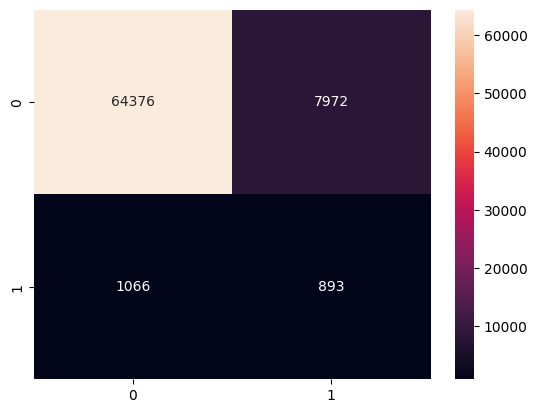

In [70]:
#External data vs Random Forest
rcf_predictions = model.predict(X)
evaluate_model(y,rcf_predictions)

#{0 Row->0 Column} -- False positive
#{0 Row->1 column} -- True positive
# number of sepsis label 1 is 15284
# while number of sepsis label 0 is 750935

In [55]:
hosp_data = df
file_name = 'created_sepsis_dataset.xlsx'
  
# saving the excel
hosp_data.to_excel(file_name)
print('DataFrame is written to Excel File successfully.')

DataFrame is written to Excel File successfully.


In [78]:
from joblib import Parallel, delayed
import joblib

joblib.dump(model, 'model.pkl')

#Load the model from the file
rfc_from_joblib = joblib.load('model.pkl')

#Use the loaded model to make predictions
rfc_from_joblib.predict(X_test)

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [77]:
result = rfc_from_joblib.score(X_test,y_test)
print(result)

0.9583469632537346
